# Agriculture data analysis: Moving towards global hunger reduction
This independent study project aims to aid countries with high hunger index(GHI) and low agricultural production per capita by using statistical analysis to distill dominant factors and recommends action plan to make improvements. Data has been  downloaded from:<br/> 
1. Food and Agriculture Organization of the United Nations(FAOSTAT) <br/>
2.  https://climateknowledgeportal.worldbank.org/download-data <br/>
3.  https://databank.worldbank.org/ <br/>
4. https://ourworldindata.org/what-is-the-gini-coefficient#:~:text=It%20measures%20inequality%20on%20a,everyone%20has%20the%20same%20income <br/>
5. https://www.globalhungerindex.org/ <br/>
In this project, the dataset is segregated into high-producing and low-producing agricultural nations. From low-producing agricultural nations, countries with high GHI are down-selected for detailed analysis. (Please refer the auxiliary notebook for details: https://github.com/saumyasucharita/Agriculture-Data-Analysis/blob/master/Exploratory%20Agriculture%20Data%20Analysis_Year%202007_FAOSTAT.ipynb) 
Countries with high-agricultural production are used as standard of reference. Dominant factors that contribute to the production of high-producing nations are obtained by statistical T-Test. Furthermore, Linear regression from the statsmodel library and Random forest model were used to assign quantitative importance(p-values) to these factors. Finally, recommendations are made to improve the agricultural yield of low-producing countries.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
import chardet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

C:\Users\saumy\AppData\Local\Temp\ipykernel_1036\673235499.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# Data Collection
## Climate Dataset

- Climate dataset is downloaded from the world bank 'Climate Change Knowledge Portal'. https://climateknowledgeportal.worldbank.org/download-data
- Data download is allowed for a maximum of three countries. Multiple files in .xlsx format were collated to a single file: Merged_climate_data.xlsx using the python script: https://github.com/saumyasucharita/Agriculture-Data-Analysis/blob/master/script/MergeClimateFiles.py
- Data Catalog:
    - **fd(Number of Frost Days (Tmin < 0°C))** - The average aggregated number of days where the daily minimum temperature is < 0°C (= Frost Days) in the data period. A negative value indicates a reduction in the number of Frost Days.
    - **pr(Precipitation in mm)** -	Aggregated accumulated precipitation.
    - **tas(Average Mean Surface Air Temperature in °C)** - Average mean temperature over the aggregation period.

In [3]:
#Data Preparation of Climate dataset
climate_data = pd.read_excel('Dataset/archive/Merged_climate_data.xlsx')
climate_data.columns = climate_data.columns.str.replace('-07', '')
climate_data

,code,name,1950,1951,1952,1953,1954,1955,1956,1957,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,SheetName
0,AGO,Angola,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,fd
1,AND,Andorra,12.52,13.23,10.87,12.00,12.39,10.18,13.64,12.21,...,11.38,11.73,9.75,9.27,10.27,10.99,9.85,10.87,9.34,fd
2,ASM,American Samoa (U.S.),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,fd
3,AGO,Angola,45.40,62.05,65.64,84.28,52.09,84.92,86.49,106.08,...,87.80,89.09,91.35,90.15,97.34,87.53,92.94,87.56,100.19,pr
4,AND,Andorra,79.64,111.16,93.81,77.02,87.54,83.76,86.19,85.32,...,86.50,115.51,110.31,86.19,83.41,91.09,124.84,95.41,104.33,pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,ALB,Albania,86.20,90.25,111.80,74.71,100.59,124.79,115.01,98.20,...,113.45,115.90,116.14,95.40,127.12,96.53,125.68,105.76,95.45,pr
620,DZA,Algeria,5.15,7.24,4.92,6.25,5.42,6.07,5.13,8.44,...,6.15,5.65,6.11,5.88,5.24,4.86,7.42,5.96,4.23,pr
621,AFG,Afghanistan,10.00,10.92,11.05,11.35,11.10,11.94,11.69,9.83,...,11.59,12.83,12.31,12.95,13.74,13.53,13.72,12.96,12.31,tas
622,ALB,Albania,13.19,12.81,12.98,11.92,11.51,12.19,11.40,12.26,...,13.06,13.20,13.15,13.26,13.16,13.13,13.73,13.57,13.37,tas


### Reshape climate dataset using melt and pivot

In [4]:
# Unpivot the DataFrame
climate_data = pd.melt(climate_data, id_vars=['code', 'name', 'SheetName'], var_name='Year', value_name='Value')
climate_data

,code,name,SheetName,Year,Value
0,AGO,Angola,fd,1950,0.00
1,AND,Andorra,fd,1950,12.52
2,ASM,American Samoa (U.S.),fd,1950,0.00
3,AGO,Angola,pr,1950,45.40
4,AND,Andorra,pr,1950,79.64
...,...,...,...,...,...
44299,ALB,Albania,pr,2020,95.45
44300,DZA,Algeria,pr,2020,4.23
44301,AFG,Afghanistan,tas,2020,12.31
44302,ALB,Albania,tas,2020,13.37


In [5]:
climate_data.columns = ['Country_Code', 'Country', 'Climate Variables', 'Year', 'Value']

In [6]:
#Pivot the Climate Variables values as columns
climate_data = climate_data.pivot_table(index=['Country_Code', 'Country', 'Year'], columns='Climate Variables', values='Value')
climate_data.reset_index(inplace=True)
climate_data

Climate Variables,Country_Code,Country,Year,fd,pr,tas
0,ABW,Aruba (Neth.),1950,0.0,87.00,25.89
1,ABW,Aruba (Neth.),1951,0.0,50.20,26.56
2,ABW,Aruba (Neth.),1952,0.0,44.75,26.58
3,ABW,Aruba (Neth.),1953,0.0,44.66,26.59
4,ABW,Aruba (Neth.),1954,0.0,70.32,26.07
...,...,...,...,...,...,...
14763,ZWE,Zimbabwe,2016,0.0,59.72,22.36
14764,ZWE,Zimbabwe,2017,0.0,81.14,21.23
14765,ZWE,Zimbabwe,2018,0.0,56.38,21.93
14766,ZWE,Zimbabwe,2019,0.0,50.78,22.45


In [7]:
climate_data.rename(columns={'fd': 'No of frost days', 'pr': 'Precipitation', 'tas':'Avg temperature'}, inplace=True)

### Data Visualization


In [8]:
# Data Visualization 
# ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
# [Ethiopia, Nigeria, Kenya, India, Cambodia, Indonesia]

def plot_histplot(df, factor, xlabel):
    # Create lists of countries to include in each subplot
    countries_group1 = ['Greece', 'Denmark', 'Uruguay', 'New Zealand', 'Argentina']
    countries_group2 = ['Ethiopia', 'India', 'Kenya', 'Indonesia', 'Bangladesh']

    # Create a dictionary to map colors to countries
    country_colors = {
        'New Zealand': 'blue',
        'Denmark': 'red',
        'Argentina': 'green',
        'Uruguay': 'orange',
        'Greece': 'purple',
        'Ethiopia': 'brown',
        'Bangladesh': 'pink',
        'Kenya': 'gray',
        'India': 'cyan',
        'Indonesia': 'lime',
    }

    # Filter the data for the selected countries
    filtered_data = df[df['Country'].isin(countries_group1 + countries_group2)]
    filtered_data = filtered_data[~pd.isna(filtered_data)]

    # Create subplots with shared x-axis limits
    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # Subplot 1 for countries_group1
    axes[0].set_title('Group 1: '+factor)
    for country in countries_group1:
        axes[0].hist(filtered_data[filtered_data['Country'] == country][factor], bins=20, alpha=0.5, label=country, color=country_colors[country])
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Frequency')
    axes[0].legend(loc='upper right')

    # Subplot 2 for countries_group2
    axes[1].set_title('Group 2: '+factor)
    for country in countries_group2:
        axes[1].hist(filtered_data[filtered_data['Country'] == country][factor], bins=20, alpha=0.5, label=country, color=country_colors[country])
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Frequency')
    axes[1].legend(loc='upper left')

    # Set the same x-axis limits for both subplots
#     plt.xlim([min(filtered_data[factor]), max(filtered_data[factor])])

    plt.tight_layout()
    plt.show()


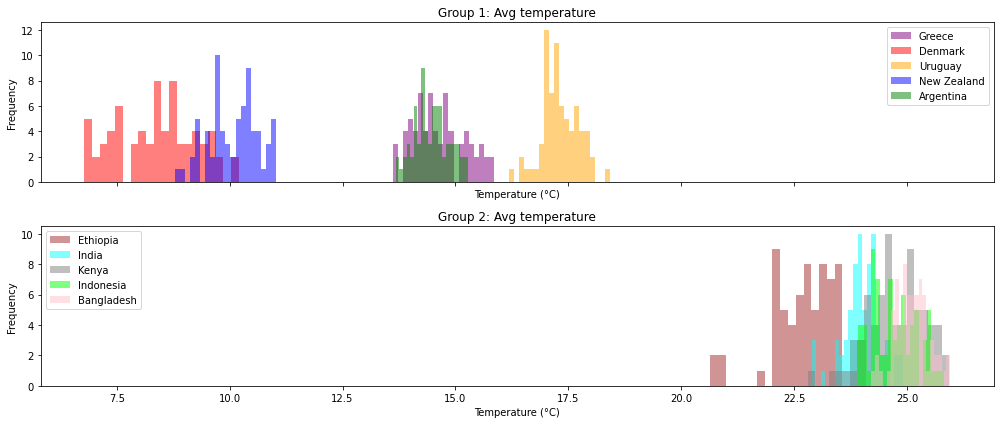

In [9]:
plot_histplot(climate_data, 'Avg temperature', 'Temperature (°C)')

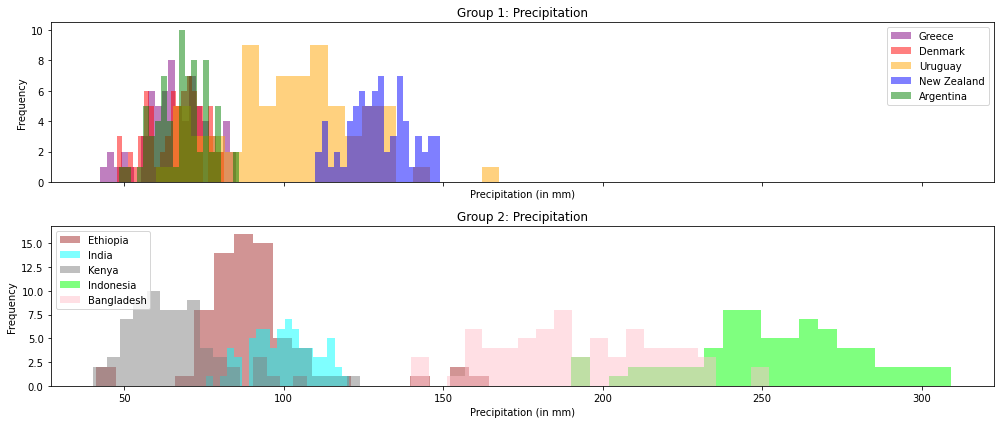

In [10]:
plot_histplot(climate_data, 'Precipitation', 'Precipitation (in mm)')

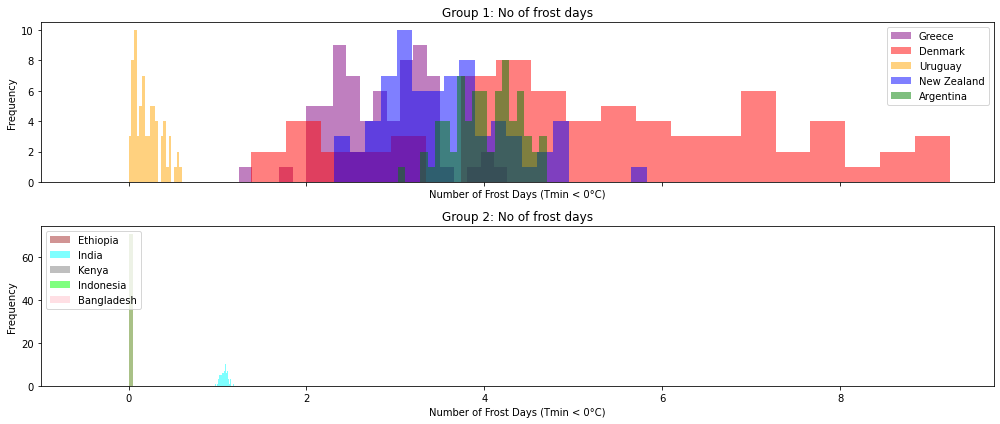

In [11]:
plot_histplot(climate_data, 'No of frost days', 'Number of Frost Days (Tmin < 0°C)')

Observations:


## FAOSTAT Credit to Agriculture

In [12]:
#Import FAOSTAT Credit to Agriculture
faostat_credit = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Credit_To_Agriculture.csv')
faostat_credit.dropna(inplace = True)
faostat_credit = faostat_credit[['Area', 'Year', 'Value']]
#Unit - million USD, Item - Credit to Agriculture, Forestry and Fishing
faostat_credit['Value'] = faostat_credit['Value'] * 1000000
faostat_credit.rename(columns={'Area': 'Country', 'Value': 'Credit to Agriculture'}, inplace=True)
faostat_credit

,Country,Year,Credit to Agriculture
0,Afghanistan,2008,1034834.0
1,Afghanistan,2010,12057230.0
2,Afghanistan,2011,12873551.0
3,Afghanistan,2012,16202029.0
4,Afghanistan,2013,20186627.0
...,...,...,...
1317,Vanuatu,2018,8382627.0
1318,Vanuatu,2019,8496907.0
1319,Vanuatu,2020,8003987.0
1320,Vanuatu,2021,9758280.0


### Data Visualization

In [13]:
countries_group1 = ['Greece', 'Denmark', 'Uruguay', 'New Zealand', 'Argentina']
countries_group2 = ['Ethiopia', 'India', 'Kenya', 'Indonesia', 'Bangladesh']


def plot_lineplot(df, factor, title):

    # Create a figure and axis
    fig, ax3 = plt.subplots(1, figsize=(16, 8))
    
    country_colors = {
        'New Zealand': 'blue',
        'Denmark': 'red',
        'Argentina': 'green',
        'Uruguay': 'orange',
        'Greece': 'purple',
        'Ethiopia': 'brown',
        'Bangladesh': 'pink',
        'Kenya': 'gray',
        'India': 'cyan',
        'Indonesia': 'lime',
    }

    # Filter the data for a specific country
    for i, country in enumerate(countries_group1 + countries_group2):
        country_data = df[df['Country'] == country]

    # Create a line plot for "Use of IMF credit" over the years
        plt.plot(country_data['Year'], country_data[factor], label=country, color=country_colors[country])
    plt.xlabel('Year')
    plt.ylabel(factor)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()



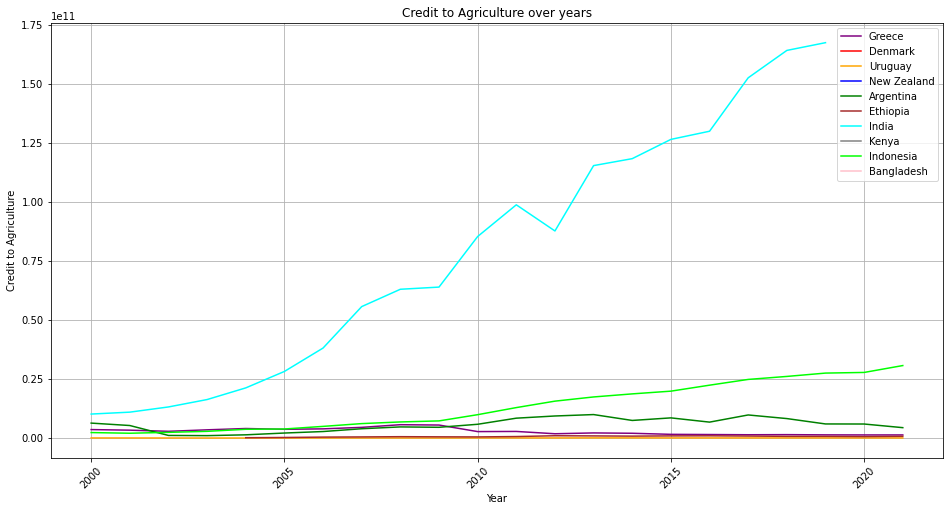

In [14]:
plot_lineplot(faostat_credit, 'Credit to Agriculture', 'Credit to Agriculture over years')

## FAOSTAT FDI inflows to Agriculture

In [15]:
#Import FAOSTAT FDI Inflows to Agriculture
faostat_fdi_inflows = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_FDI_Inflows_to_Agriculture.csv')
faostat_fdi_inflows.dropna(inplace = True)
faostat_fdi_inflows = faostat_fdi_inflows[['Area', 'Element', 'Item', 'Year', 'Unit', 'Value']]
faostat_fdi_inflows = faostat_fdi_inflows[faostat_fdi_inflows['Element'] == 'Value US$']
#Unit - million USD Item - FDI inflows to Agriculture, Forestry and Fishing
faostat_fdi_inflows['Value'] = faostat_fdi_inflows['Value'] * 1000000

faostat_fdi_inflows = faostat_fdi_inflows[['Area', 'Year', 'Value']]
faostat_fdi_inflows.rename(columns={'Area': 'Country', 'Value': 'FDI inflows to Agriculture'}, inplace=True)
faostat_fdi_inflows

,Country,Year,FDI inflows to Agriculture
0,Albania,2004,642888.0
2,Albania,2005,494601.0
4,Albania,2006,2508966.0
6,Albania,2007,2737334.0
8,Albania,2008,-79100597.0
...,...,...,...
3874,Zambia,2017,-13400000.0
3876,Zambia,2018,-147700000.0
3878,Zimbabwe,1993,3532245.0
3880,Zimbabwe,1994,2110031.0


In [16]:
faostat_fdi_inflows_India = faostat_fdi_inflows[faostat_fdi_inflows['Country'] == 'India']
faostat_fdi_inflows_India

,Country,Year,FDI inflows to Agriculture
1510,India,1990,31993601.0
1512,India,1991,21105952.0
1514,India,1992,8874107.0
1516,India,1993,7214700.0
1518,India,1994,30280139.0
1520,India,2003,2000000.0
1522,India,2004,10000000.0


### Data Visualization

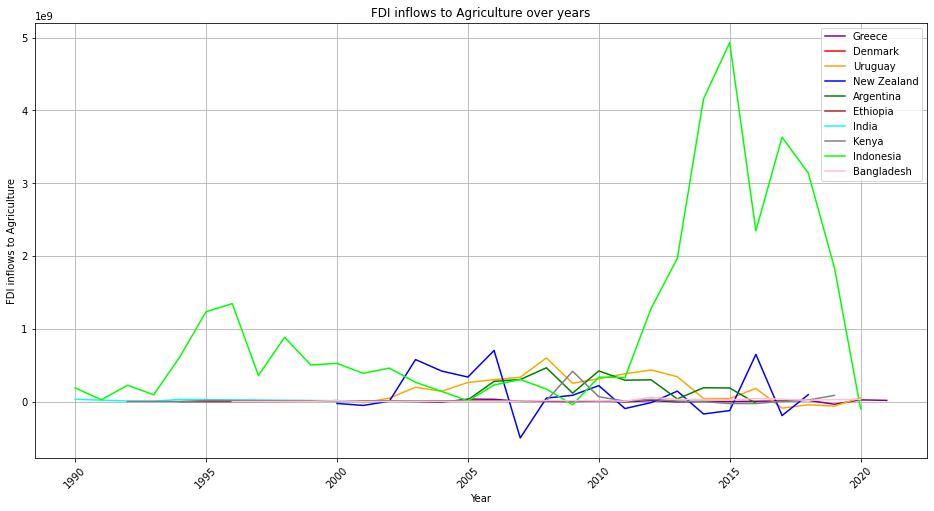

In [17]:
plot_lineplot(faostat_fdi_inflows, 'FDI inflows to Agriculture', 'FDI inflows to Agriculture over years')

## FAOSTAT Agriculture share of Government Expenditure/Water Use Efficiency(Agriculture)

In [18]:
#Import FAOSTAT SDG Indicators
faostat_sdg_indicators = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_SDG_Indicators.csv')
faostat_sdg_indicators.dropna(inplace = True)
faostat_sdg_indicators = faostat_sdg_indicators[(faostat_sdg_indicators['Item'] == '2.a.1 Agriculture share of Government Expenditure') |
    (faostat_sdg_indicators['Item'] == '6.4.1 Water Use Efficiency (Agriculture (ISIC4 A01 A0210 A0322))')]

faostat_sdg_indicators

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (SDG),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2001,2001,%,7.31,E,Estimated value,Estimated | FAO Imputed Data | Budgetary Centr...
1,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2002,2002,%,7.33,E,Estimated value,Estimated | FAO Imputed Data | Budgetary Centr...
2,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2003,2003,%,5.33,A,Official figure,Country Data | Data from the International Mon...
3,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2004,2004,%,14.51,A,Official figure,Country Data | Data from the International Mon...
4,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2005,2005,%,4.68,A,Official figure,Country Data | Data from the International Mon...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18517,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2016,2016,USD/m3,0.04,A,Official figure,Global monitoring data | Food and Agriculture ...
18518,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2017,2017,USD/m3,0.05,A,Official figure,Global monitoring data | Food and Agriculture ...
18519,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2018,2018,USD/m3,0.04,A,Official figure,Global monitoring data | Food and Agriculture ...
18520,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2019,2019,USD/m3,0.04,A,Official figure,Global monitoring data | Food and Agriculture ...


In [19]:
faostat_sdg_indicators.rename(columns={'Area': 'Country'}, inplace=True)

### Reshape dataset using pivot

In [20]:
faostat_sdg_indicators = faostat_sdg_indicators[['Country', 'Item', 'Year', 'Value']]

#Agriculture share of Government Expenditure - %, Water Use Efficiency (Agriculture) - USD/m3
faostat_sdg_indicators = faostat_sdg_indicators.pivot_table(index=['Country', 'Year'], columns='Item', values='Value')
faostat_sdg_indicators

Item              2.a.1 Agriculture share of Government Expenditure  \
Country     Year                                                      
Afghanistan 2000                                                NaN   
            2001                                               7.31   
            2002                                               7.33   
            2003                                               5.33   
            2004                                              14.51   
...                                                             ...   
Zimbabwe    2016                                                NaN   
            2017                                                NaN   
            2018                                                NaN   
            2019                                                NaN   
            2020                                              12.24   

Item              6.4.1 Water Use Efficiency (Agriculture (ISIC4 A01 A0210 A0322))  
Country     Year                                                                    
Afghanistan 2000                                               0.06                 
            2001                                               0.06                 
            2002                                               0.08                 
            2003                                               0.07                 
            2004                                               0.08                 
...                                                             ...                 
Zimbabwe    2016                                               0.04                 
            2017                                               0.05                 
            2018                                               0.04                 
            2019                                               0.04                 
            2020                                               0.04                 

[4015 rows x 2 columns]

In [21]:
faostat_sdg_indicators.rename(columns={'2.a.1 Agriculture share of Government Expenditure': 'Agriculture share of Government Expenditure'}, inplace=True)
faostat_sdg_indicators.rename(columns={'6.4.1 Water Use Efficiency (Agriculture (ISIC4 A01 A0210 A0322))': 'Water Use Efficiency'}, inplace=True)
faostat_sdg_indicators = faostat_sdg_indicators.reset_index()

faostat_sdg_indicators

Item,Country,Year,Agriculture share of Government Expenditure,Water Use Efficiency
0,Afghanistan,2000,NaN,0.06
1,Afghanistan,2001,7.31,0.06
2,Afghanistan,2002,7.33,0.08
3,Afghanistan,2003,5.33,0.07
4,Afghanistan,2004,14.51,0.08
...,...,...,...,...
4010,Zimbabwe,2016,NaN,0.04
4011,Zimbabwe,2017,NaN,0.05
4012,Zimbabwe,2018,NaN,0.04
4013,Zimbabwe,2019,NaN,0.04


### Data Visualization

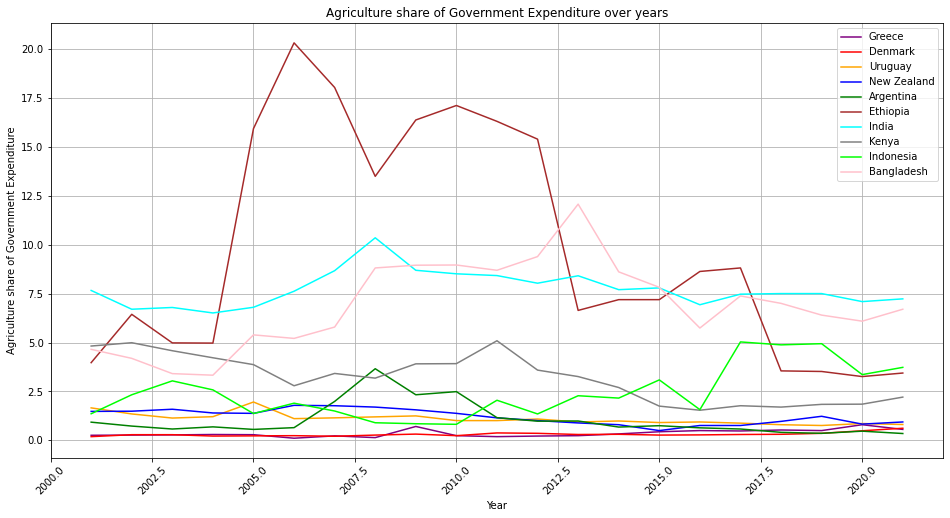

In [22]:
plot_lineplot(faostat_sdg_indicators, 'Agriculture share of Government Expenditure', 'Agriculture share of Government Expenditure over years')

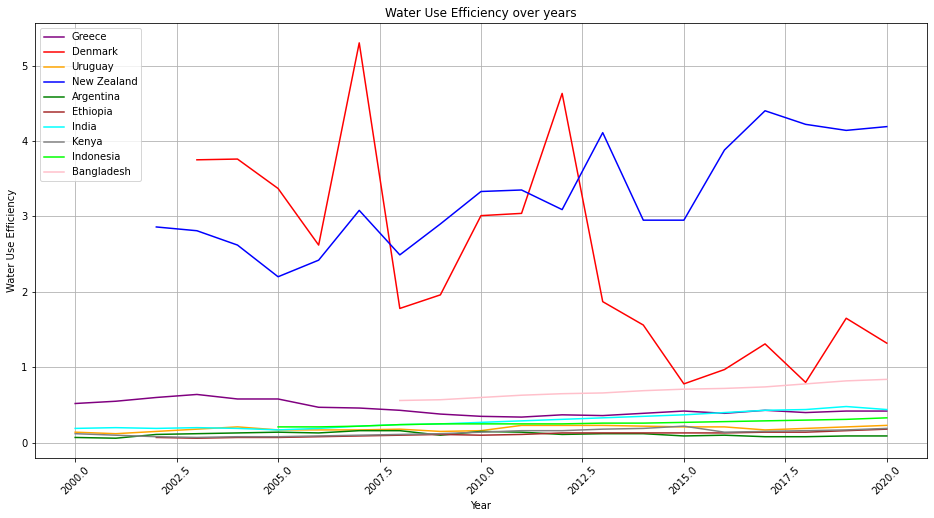

In [23]:
plot_lineplot(faostat_sdg_indicators, 'Water Use Efficiency', 'Water Use Efficiency over years')

## World Bank Education Data

In [24]:
#Import World Bank Education Data
world_bank_edu = pd.read_csv('Dataset/archive/World_Bank_Education.csv')
world_bank_edu.dropna(inplace = True)
world_bank_edu.columns = [col.split(' [')[0] for col in world_bank_edu.columns]
world_bank_edu.drop('Series Code', axis=1, inplace=True)
world_bank_edu

,Country Name,Country Code,Series,1960,1961,1962,1963,1964,1965,1966,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, bo...",..,..,..,..,..,..,..,...,65.79363,..,..,..,64.43013,..,..,..,..,..
1,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,51.30789,..,..,..,49.19871,..,..,..,..,..
2,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, ma...",..,..,..,..,..,..,..,...,79.51016,..,..,..,78.91602,..,..,..,..,..
3,Albania,ALB,"Gross enrolment ratio, primary to tertiary, bo...",..,..,..,..,..,..,..,...,88.73256,87.41363,85.23001,84.96134,83.89356,85.01313,..,..,..,..
4,Albania,ALB,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,92.07545,90.64685,88.91327,89.25792,88.64442,90.16838,..,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
812,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, ma...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
813,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, bo...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
814,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


### Reshape dataset using melt

In [25]:
world_bank_edu = pd.melt(world_bank_edu, id_vars=['Country Name', 'Country Code', 'Series'], var_name='Year', value_name='Value')
world_bank_edu

,Country Name,Country Code,Series,Year,Value
0,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, bo...",1960,..
1,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, fe...",1960,..
2,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, ma...",1960,..
3,Albania,ALB,"Gross enrolment ratio, primary to tertiary, bo...",1960,..
4,Albania,ALB,"Gross enrolment ratio, primary to tertiary, fe...",1960,..
...,...,...,...,...,...
52219,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, fe...",2023,..
52220,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, ma...",2023,..
52221,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, bo...",2023,..
52222,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, fe...",2023,..


### Data cleaning

In [26]:
# world_bank_edu.replace('..', 0.0, inplace=True) 
world_bank_edu['Value'] = world_bank_edu['Value'].replace('..', pd.NA)

# Drop rows where 'Value' is NaN
world_bank_edu = world_bank_edu.dropna(subset=['Value'])

In [27]:
world_bank_edu = world_bank_edu.pivot_table(index=['Country Name', 'Country Code', 'Year'], columns='Series', values='Value')
world_bank_edu.reset_index(inplace=True)
world_bank_edu.rename(columns={'Country Name': 'Country'}, inplace=True)
world_bank_edu.drop('Country Code', axis=1, inplace=True)
world_bank_edu

Series,Country,Year,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)"
0,Afghanistan,1970,16.05820,4.50856,27.41987
1,Afghanistan,1971,16.86606,NaN,NaN
2,Afghanistan,1972,17.40084,4.74242,29.74823
3,Afghanistan,1973,17.80448,5.07726,30.16882
4,Afghanistan,1974,18.09427,5.11067,30.66925
...,...,...,...,...,...
5895,Zimbabwe,2001,62.81822,60.43868,65.22950
5896,Zimbabwe,2002,59.85826,57.56935,62.19583
5897,Zimbabwe,2003,57.87850,55.73510,60.08197
5898,Zimbabwe,2012,66.51386,64.46115,68.64404


### Data Visualization

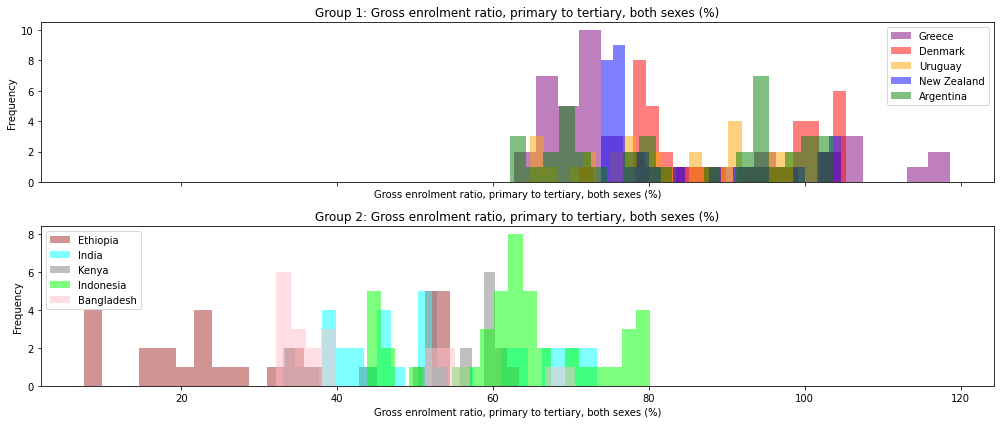

In [28]:
plot_histplot(world_bank_edu, 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Gross enrolment ratio, primary to tertiary, both sexes (%)')

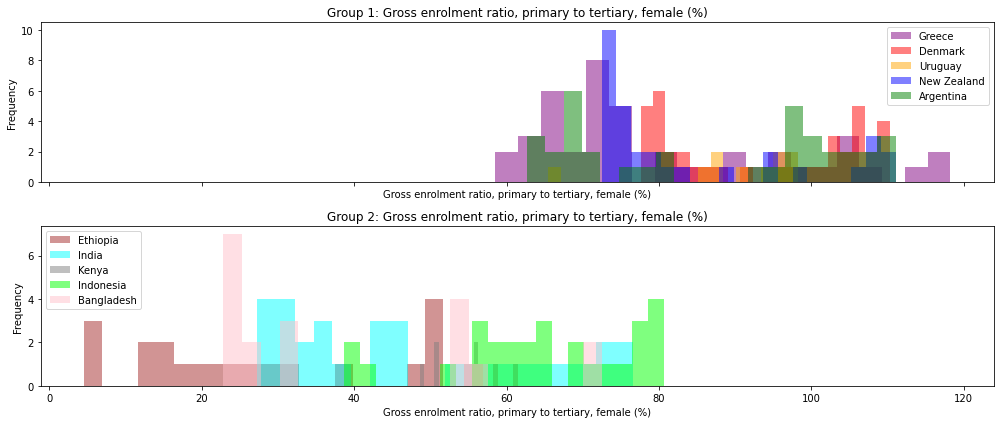

In [29]:
plot_histplot(world_bank_edu, 'Gross enrolment ratio, primary to tertiary, female (%)', 'Gross enrolment ratio, primary to tertiary, female (%)')

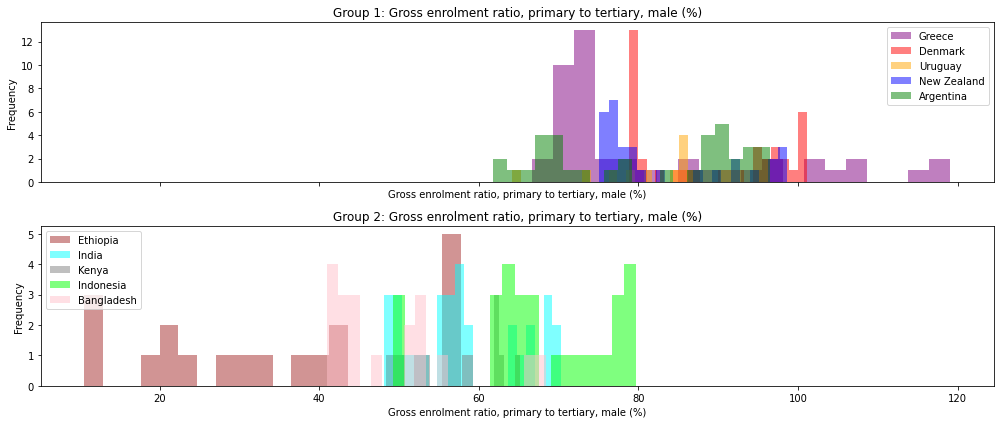

In [30]:
plot_histplot(world_bank_edu, 'Gross enrolment ratio, primary to tertiary, male (%)', 'Gross enrolment ratio, primary to tertiary, male (%)')

## GINI Coefficient

In [31]:
#GINI Index
world_GINI_index = pd.read_csv('Dataset/archive/economic-inequality-gini-index.csv')
world_GINI_index = world_GINI_index.rename(columns={'Entity': 'Country Name'})
world_GINI_index.rename(columns={'Country Name': 'Country'}, inplace=True)
world_GINI_index.drop('Code', axis=1, inplace=True)

world_GINI_index

,Country,Year,Gini coefficient
0,Albania,1996,0.270103
1,Albania,2002,0.317390
2,Albania,2005,0.305957
3,Albania,2008,0.299847
4,Albania,2012,0.289605
...,...,...,...
2120,Zambia,2010,0.556215
2121,Zambia,2015,0.571361
2122,Zimbabwe,2011,0.431536
2123,Zimbabwe,2017,0.443371


In [32]:
world_GINI_Kenya = world_GINI_index[world_GINI_index['Country'] == 'Kenya']
world_GINI_Kenya

,Country,Year,Gini coefficient
1127,Kenya,1992,0.574610
1128,Kenya,1994,0.431086
1129,Kenya,1997,0.449831
1130,Kenya,2005,0.464529
1131,Kenya,2015,0.407758


In [33]:
world_GINI_India = world_GINI_index[world_GINI_index['Country'] == 'India']
world_GINI_India

,Country,Year,Gini coefficient
883,India,1977,0.333366
884,India,1983,0.321010
885,India,1987,0.325742
886,India,1993,0.316962
887,India,2004,0.344063
888,India,2009,0.353803
889,India,2011,0.357126
890,India,2015,0.347064
891,India,2016,0.347732
892,India,2017,0.359430


### Data Visualization

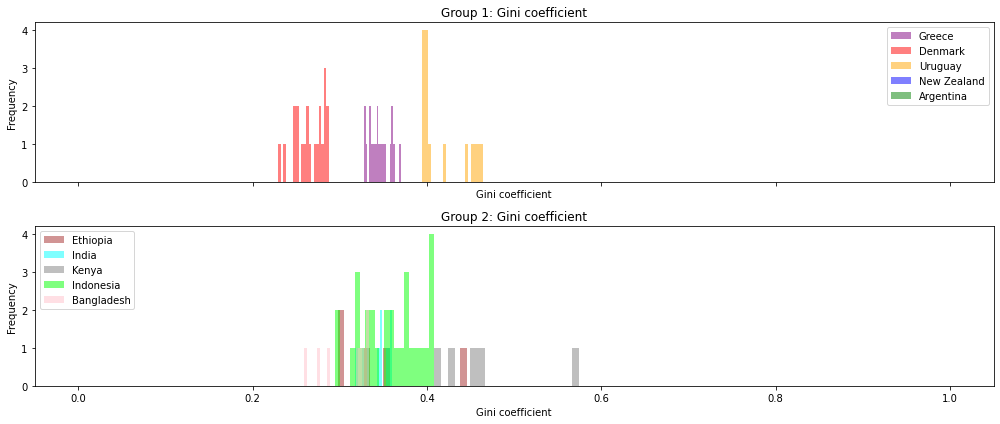

In [34]:
plot_histplot(world_GINI_index, 'Gini coefficient', 'Gini coefficient')

In [35]:
world_GINI_index_2007 = world_GINI_index.loc[world_GINI_index['Year'] <= 2007]

## FAOSTAT Land Use

In [36]:
#Land data
agri_land_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Land_Use.csv')
#Unit - 1000 ha
agri_land_data = agri_land_data[['Area', 'Year', 'Value']]
agri_land_data.rename(columns={'Area': 'Country', 'Value':'Area'}, inplace=True)

agri_land_data

,Country,Year,Area
0,Afghanistan,1961,37750.0
1,Afghanistan,1962,37800.0
2,Afghanistan,1963,37850.0
3,Afghanistan,1964,37905.0
4,Afghanistan,1965,37910.0
...,...,...,...
13045,Zimbabwe,2017,16200.0
13046,Zimbabwe,2018,16200.0
13047,Zimbabwe,2019,16200.0
13048,Zimbabwe,2020,16200.0


### Data Visualization

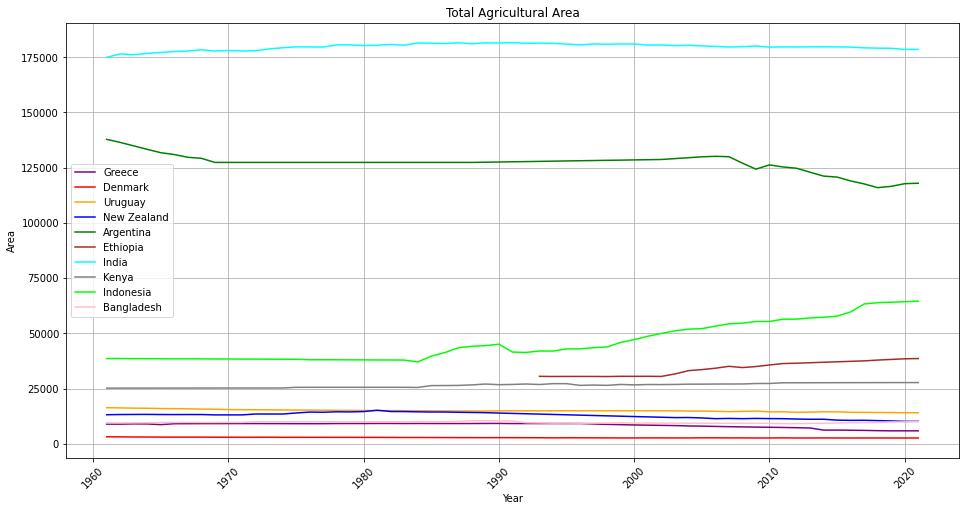

In [37]:


plot_lineplot(agri_land_data, 'Area', 'Total Agricultural Area')

## FAOSTAT Fertilizers By Nutrient

In [38]:
# Year varies from 1961 to 2021
# Unit kg/pc
#'Use per area of cropland', 'Use per capita'
# Estimated value
world_fertilizer_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Fertilizers_By_Nutrient.csv') 
world_fertilizer_data = world_fertilizer_data[world_fertilizer_data['Element']=='Use per capita']
world_fertilizer_data = world_fertilizer_data[['Area', 'Year', 'Item', 'Value']]
grouped_fertilizer_df = world_fertilizer_data.groupby(['Area', 'Year', 'Item'])['Value'].sum().reset_index()
pivot_df = grouped_fertilizer_df.pivot_table(index=['Area', 'Year'], columns='Item', values='Value', fill_value=0).reset_index()
pivot_df['Sum'] =  pivot_df['Nutrient nitrogen N (total)'] + pivot_df['Nutrient phosphate P2O5 (total)'] + pivot_df['Nutrient potash K2O (total)']
fertilizer_data = pivot_df[['Area', 'Year', 'Sum']]
fertilizer_data.columns = ['Country', 'Year', 'Fertilizer Use Per Capita']
fertilizer_data

,Country,Year,Fertilizer Use Per Capita
0,Afghanistan,1961,0.12
1,Afghanistan,1962,0.12
2,Afghanistan,1963,0.12
3,Afghanistan,1964,0.12
4,Afghanistan,1965,0.11
...,...,...,...
10279,Zimbabwe,2017,9.93
10280,Zimbabwe,2018,8.82
10281,Zimbabwe,2019,8.64
10282,Zimbabwe,2020,6.64


In [39]:
world_fertilizer_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Fertilizers_By_Nutrient.csv') 

world_fertilizer_data = world_fertilizer_data[['Area', 'Year', 'Element', 'Item', 'Value']]
pivot_df = world_fertilizer_data.pivot_table(index=['Area', 'Year'], columns=['Element', 'Item'], values='Value', fill_value=0).reset_index()

pivot_df['Total Use per area'] = pivot_df['Use per area of cropland']['Nutrient nitrogen N (total)'] + pivot_df['Use per area of cropland']['Nutrient phosphate P2O5 (total)'] + pivot_df['Use per area of cropland']['Nutrient potash K2O (total)']
pivot_df['Total Use per capita'] = pivot_df['Use per capita']['Nutrient nitrogen N (total)'] + pivot_df['Use per capita']['Nutrient phosphate P2O5 (total)'] + pivot_df['Use per capita']['Nutrient potash K2O (total)']
fertilizer_data = pivot_df[['Area', 'Year', 'Total Use per area', 'Total Use per capita']]
fertilizer_data.columns = ['Country', 'Year', 'Fertilizer Use Per Area', 'Fertilizer Use Per Capita']
fertilizer_data

,Country,Year,Fertilizer Use Per Area,Fertilizer Use Per Capita
0,Afghanistan,1961,0.14,0.12
1,Afghanistan,1962,0.14,0.12
2,Afghanistan,1963,0.14,0.12
3,Afghanistan,1964,0.14,0.12
4,Afghanistan,1965,0.14,0.11
...,...,...,...,...
10279,Zimbabwe,2017,35.71,9.93
10280,Zimbabwe,2018,32.39,8.82
10281,Zimbabwe,2019,32.39,8.64
10282,Zimbabwe,2020,25.34,6.64


### Data Visualization

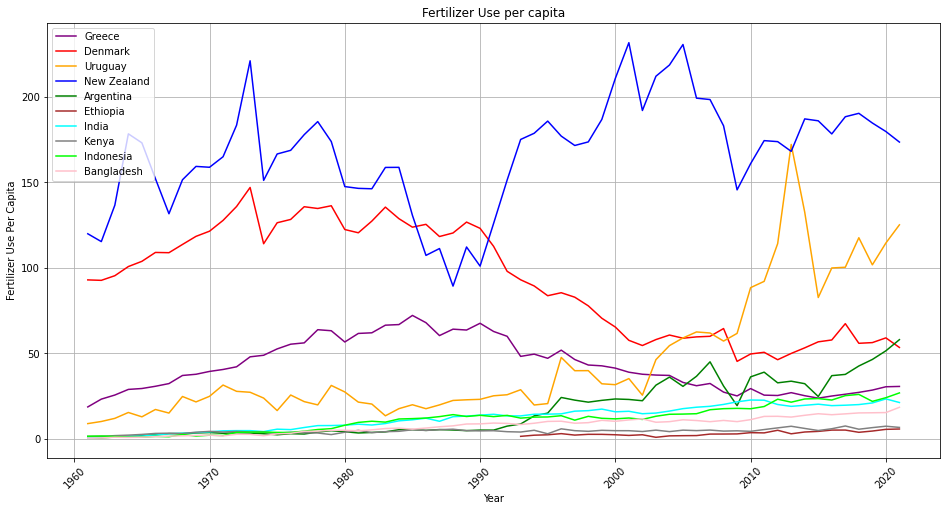

In [40]:
# countries_group1 = ['Greece', 'Denmark', 'Uruguay', 'New Zealand', 'Argentina']
# countries_group2 = [Ethiopia, Nigeria, Kenya, India, Cambodia, Indonesia]

plot_lineplot(fertilizer_data, 'Fertilizer Use Per Capita', 'Fertilizer Use per capita')

"2011 PPP$" in FAO data, means that the values have been adjusted to a common standard (2011) to facilitate cross-country comparisons. This is important in agricultural and economic analyses to account for differences in the cost of living and inflation rates between countries.

## FAOSTAT Agricultural Production

### Reshape dataset using pivot

In [41]:
#Combine all datasets with the FAO Agriculture data
prod_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Agricultural_Production.csv')
prod_data = prod_data[prod_data['Element'] == 'Gross Production Value (current thousand US$)']
#Unit 1000 USD
prod_data = prod_data[['Area', 'Item', 'Year', 'Value']]
prod_pivot_df = prod_data.pivot_table(index=['Area', 'Year'], columns='Item', values='Value', fill_value=0).reset_index()

prod_pivot_df

Item,Area,Year,"Cereals, primary",Crops,Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables and Fruit Primary
0,Albania,1993,138878,514773,903481,32537,1527,294623
1,Albania,1994,138401,465461,926834,30071,2574,261637
2,Albania,1995,110829,369362,772311,30336,2287,179849
3,Albania,1996,148905,419407,812658,37777,3206,180195
4,Albania,1997,140956,376468,726542,29527,1789,156701
...,...,...,...,...,...,...,...,...
4583,Zimbabwe,2014,370710,1044297,651847,0,0,0
4584,Zimbabwe,2015,286328,2960358,2705213,17509,1794528,351531
4585,Zimbabwe,2016,246303,3341027,3022789,19378,1915650,578366
4586,Zimbabwe,2017,663682,3382657,3243116,21348,1779974,446404


In [42]:
prod_pivot_df['Total Agri Production'] =  prod_pivot_df['Cereals, primary'] + prod_pivot_df['Crops'] + prod_pivot_df['Food'] + prod_pivot_df['Roots and Tubers, Total'] + prod_pivot_df['Sugar Crops Primary'] + prod_pivot_df['Vegetables and Fruit Primary'] 
agri_prod_data = prod_pivot_df[['Area', 'Year', 'Total Agri Production']]
agri_prod_data.rename(columns={'Area':'Country'}, inplace=True)
agri_prod_data

C:\Users\saumy\AppData\Local\Temp\ipykernel_1036\527054421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agri_prod_data.rename(columns={'Area':'Country'}, inplace=True)


Item,Country,Year,Total Agri Production
0,Albania,1993,1885819
1,Albania,1994,1824978
2,Albania,1995,1464974
3,Albania,1996,1602148
4,Albania,1997,1431983
...,...,...,...
4583,Zimbabwe,2014,2066854
4584,Zimbabwe,2015,8115467
4585,Zimbabwe,2016,9123513
4586,Zimbabwe,2017,9537181


### Data Visualization

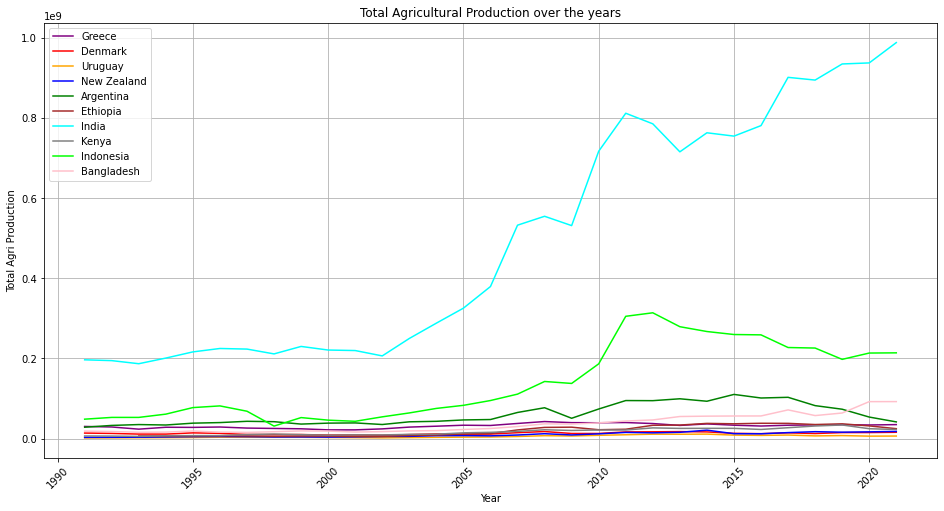

In [43]:
plot_lineplot(agri_prod_data, 'Total Agri Production', 'Total Agricultural Production over the years')

## FAOSTAT GDP 

### Reshape dataset using pivot

In [44]:
#World GDP Data
world_gdp_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_GDP.csv')
# world_gdp_data = world_gdp_data[world_gdp_data['Element'] == 'Value US$']
world_gdp_data = world_gdp_data[['Area', 'Element', 'Year', 'Value']]
pivot_gdp_df = world_gdp_data.pivot_table(index=['Area', 'Year'], columns='Element', values='Value').reset_index()
#GDP unit is in 1000 USD
pivot_gdp_df['Value US$'] = pivot_gdp_df['Value US$']*1000
world_gdp_data = pivot_gdp_df
world_gdp_data.rename(columns={'Area': 'Country', 'Value US$':'GDP(1000 USD)', 'Value US$ per capita':'GDP per capita'}, inplace=True)

world_gdp_data

Element,Country,Year,GDP(1000 USD),GDP per capita
0,Afghanistan,1970,1.731436e+06,161.019274
1,Afghanistan,1971,1.812838e+06,164.566181
2,Afghanistan,1972,1.647900e+06,146.003034
3,Afghanistan,1973,1.702716e+06,147.099044
4,Afghanistan,1974,2.061729e+06,173.694213
...,...,...,...,...
10692,Zimbabwe,2018,2.364527e+07,1570.886029
10693,Zimbabwe,2019,2.259452e+07,1471.513983
10694,Zimbabwe,2020,2.166475e+07,1382.591426
10695,Zimbabwe,2021,2.411815e+07,1507.994790


### Data Visualization

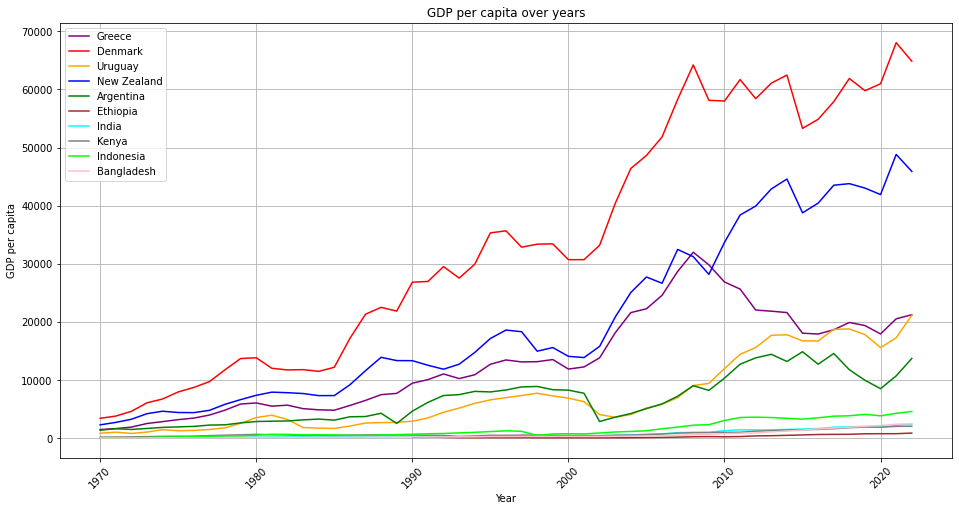

In [45]:
#Data Visualization of GDP
# countries_group1 = ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
# countries_group2 = ['Ethiopia', 'Nigeria', 'Kenya', 'India', 'Cambodia', 'Indonesia']

plot_lineplot(world_gdp_data, 'GDP per capita', 'GDP per capita over years')

## FAOSTAT Population

In [46]:
#Population data
population_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Population.csv')
population_data = population_data[['Area', 'Year', 'Unit', 'Value']]

population_data['Value'] = population_data['Value'] * 1000
population_data.drop(['Unit'], axis = 1, inplace=True)
population_data.rename(columns={'Area': 'Country', 'Value':'Population'}, inplace=True)

population_data

,Country,Year,Population
0,Afghanistan,1950,7480461.0
1,Afghanistan,1951,7571537.0
2,Afghanistan,1952,7667533.0
3,Afghanistan,1953,7764546.0
4,Afghanistan,1954,7864285.0
...,...,...,...
15538,Zimbabwe,2017,14751101.0
15539,Zimbabwe,2018,15052184.0
15540,Zimbabwe,2019,15354608.0
15541,Zimbabwe,2020,15669666.0


In [47]:
#GHI data
sheet_index = 2
GHI_data = pd.read_excel('Dataset/archive/Global_Hunger_Index_Scores.xlsx', sheet_name=sheet_index)
GHI_data.columns = GHI_data.iloc[1]
GHI_data = GHI_data.iloc[2:-3] #Delete the first and bottom 2 rows
GHI_data.columns = ['Country', '2000', '2007', '2014', '2022', 'Absolute change since 2014', '% change since 2014']
GHI_data = GHI_data[['Country', '2000', '2007', '2014', '2022']]
#The dataset contains non-numeric values like '-'
# GHI_2007['2007'] = pd.to_numeric(GHI_2007['2007'], errors='coerce')
# GHI_2007.dropna(inplace = True)
GHI_data = pd.melt(GHI_data, id_vars=['Country'], var_name='Year', value_name='GHI')
GHI_data

,Country,Year,GHI
0,Afghanistan,2000,50.3
1,Albania,2000,20.7
2,Algeria,2000,14.5
3,Angola,2000,64.9
4,Argentina,2000,6.6
...,...,...,...
539,Venezuela (Boliv. Rep. of),2022,19.9
540,Viet Nam,2022,11.9
541,Yemen,2022,45.1
542,Zambia,2022,29.3


# Combine all datasets with the FAO Agriculture data

In [48]:
#Merge with GDP Data
agri_data = pd.merge(agri_prod_data, world_gdp_data, how='inner', on=['Country','Year'])
#Climate data
climate_data['Year']=climate_data['Year'].astype(pd.Int64Dtype())
agri_data = pd.merge(agri_data, climate_data, how='inner', on=['Country','Year']) 
#Socio-economic data

# agri_data = pd.merge(agri_data, world_bank_data, how='inner', on=['Country','Year']) 

world_bank_edu['Year']=world_bank_edu['Year'].astype(pd.Int64Dtype())
agri_data = pd.merge(agri_data, world_bank_edu, how='inner', on=['Country','Year'])

agri_land_data['Year']=agri_land_data['Year'].astype(pd.Int64Dtype())
agri_data = pd.merge(agri_data, agri_land_data, how='inner', on=['Country','Year'])

agri_data = pd.merge(agri_data, population_data, how='inner', on=['Country','Year'])

agri_data = pd.merge(agri_data, fertilizer_data, how='inner', on=['Country','Year'])

agri_data = pd.merge(agri_data, faostat_credit, how='left', on=['Country','Year'])

agri_data = pd.merge(agri_data, faostat_fdi_inflows, how='left', on=['Country','Year'])

agri_data = pd.merge(agri_data, faostat_sdg_indicators, how='left', on=['Country','Year'])

agri_data

,Country,Year,Total Agri Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency
0,Albania,1993,1885819,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,62.71862,60.94200,1126.0,3300711.0,25.49,5.42,NaN,NaN,NaN,NaN
1,Albania,1994,1824978,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,61.85745,62.26813,1126.0,3293999.0,21.04,4.48,NaN,NaN,NaN,NaN
2,Albania,1995,1464974,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,61.83495,63.89844,1127.0,3284364.0,15.67,3.34,NaN,NaN,NaN,NaN
3,Albania,1996,1602148,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,62.58842,64.19750,1131.0,3271331.0,9.25,1.99,NaN,NaN,NaN,NaN
4,Albania,1997,1431983,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,64.14992,66.18734,1135.0,3253719.0,7.43,1.60,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015,8833548,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,NaN,NaN,14467.6,3402818.0,102.52,82.61,48841471.0,42023232.0,0.91,0.21
1943,Uruguay,2016,8067775,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,NaN,NaN,14265.3,3413766.0,135.50,99.90,45199938.0,182055671.0,0.94,0.21
1944,Uruguay,2017,8943169,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,NaN,NaN,14222.9,3422200.0,138.98,100.32,45811604.0,-88928363.0,0.88,0.17
1945,Zimbabwe,2012,1824286,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,64.46115,68.64404,16200.0,13265331.0,17.81,5.50,NaN,NaN,5.67,0.04


In [49]:
#Merge with GINI Index
agri_data = pd.merge(agri_data, world_GINI_index, how='left', on=['Country','Year'])
agri_data

,Country,Year,Total Agri Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)",...,"Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient
0,Albania,1993,1885819,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,...,60.94200,1126.0,3300711.0,25.49,5.42,NaN,NaN,NaN,NaN,NaN
1,Albania,1994,1824978,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,...,62.26813,1126.0,3293999.0,21.04,4.48,NaN,NaN,NaN,NaN,NaN
2,Albania,1995,1464974,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,...,63.89844,1127.0,3284364.0,15.67,3.34,NaN,NaN,NaN,NaN,NaN
3,Albania,1996,1602148,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,...,64.19750,1131.0,3271331.0,9.25,1.99,NaN,NaN,NaN,NaN,0.270103
4,Albania,1997,1431983,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,...,66.18734,1135.0,3253719.0,7.43,1.60,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015,8833548,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,...,NaN,14467.6,3402818.0,102.52,82.61,48841471.0,42023232.0,0.91,0.21,0.401288
1943,Uruguay,2016,8067775,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,...,NaN,14265.3,3413766.0,135.50,99.90,45199938.0,182055671.0,0.94,0.21,0.396955
1944,Uruguay,2017,8943169,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,...,NaN,14222.9,3422200.0,138.98,100.32,45811604.0,-88928363.0,0.88,0.17,0.394645
1945,Zimbabwe,2012,1824286,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,...,68.64404,16200.0,13265331.0,17.81,5.50,NaN,NaN,5.67,0.04,NaN


In [50]:
agri_data['Agri_Prod_Per_Capita'] = (agri_data['Total Agri Production']/agri_data['Population'])*1000
agri_data

,Country,Year,Total Agri Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)",...,Area,Population,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Agri_Prod_Per_Capita
0,Albania,1993,1885819,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,...,1126.0,3300711.0,25.49,5.42,NaN,NaN,NaN,NaN,NaN,571.337206
1,Albania,1994,1824978,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,...,1126.0,3293999.0,21.04,4.48,NaN,NaN,NaN,NaN,NaN,554.031134
2,Albania,1995,1464974,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,...,1127.0,3284364.0,15.67,3.34,NaN,NaN,NaN,NaN,NaN,446.044957
3,Albania,1996,1602148,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,...,1131.0,3271331.0,9.25,1.99,NaN,NaN,NaN,NaN,0.270103,489.754170
4,Albania,1997,1431983,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,...,1135.0,3253719.0,7.43,1.60,NaN,NaN,NaN,NaN,NaN,440.106537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015,8833548,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,...,14467.6,3402818.0,102.52,82.61,48841471.0,42023232.0,0.91,0.21,0.401288,2595.950768
1943,Uruguay,2016,8067775,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,...,14265.3,3413766.0,135.50,99.90,45199938.0,182055671.0,0.94,0.21,0.396955,2363.306389
1944,Uruguay,2017,8943169,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,...,14222.9,3422200.0,138.98,100.32,45811604.0,-88928363.0,0.88,0.17,0.394645,2613.280638
1945,Zimbabwe,2012,1824286,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,...,16200.0,13265331.0,17.81,5.50,NaN,NaN,5.67,0.04,NaN,137.522841


In [51]:
# agri_data_India = agri_data[agri_data['Country']=='Bangladesh']
# agri_data_India

In [52]:
#Find top 10 agri per capita countries
# agri_data.sort_values(by='Agri_Prod_Per_Capita', ascending = False, inplace=True)


In [53]:
# top_10_countries = agri_data['Country'].unique()[:10]
# print(top_10_countries)
# ['New Zealand' 'Greece' 'Uruguay' 'Denmark' 'Australia'
#  'Dominican Republic' 'Costa Rica' 'Tajikistan' 'Canada' 'Argentina']

In [54]:
# bottom_10_countries = agri_data['Country'].unique()[-10:]
# print(bottom_10_countries)
# ['Namibia' 'Oman' 'Botswana' 'Iraq' 'Zimbabwe' 'Bahrain' 'Guatemala'
#  'Lesotho' 'Singapore' 'Maldives']

In [55]:
agri_data.to_csv('FAO_Merged.csv', index=False)

# Handling missing values in merged dataset

In [56]:
#Missing value counts
nan_counts = agri_data.isna().sum()
nan_counts

Country                                                          0
Year                                                             0
Total Agri Production                                            0
GDP(1000 USD)                                                    0
GDP per capita                                                   0
Country_Code                                                     0
No of frost days                                                 0
Precipitation                                                    0
Avg temperature                                                  0
Gross enrolment ratio, primary to tertiary, both sexes (%)       0
Gross enrolment ratio, primary to tertiary, female (%)         197
Gross enrolment ratio, primary to tertiary, male (%)           197
Area                                                             0
Population                                                       0
Fertilizer Use Per Area                                       

In [57]:
#Before Imputation
agri_data.corr()

,Year,Total Agri Production,GDP(1000 USD),GDP per capita,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Agri_Prod_Per_Capita
Year,1.000000,0.104203,0.153844,0.249619,-0.064144,0.045603,0.075120,0.329187,0.299891,0.285448,0.012611,0.043156,0.097641,-0.006160,0.144017,0.101271,-0.114400,0.142202,-0.125510,0.274905
Total Agri Production,0.104203,1.000000,0.887013,-0.042623,0.111749,-0.013396,-0.069113,-0.013372,-0.013371,-0.011953,0.676044,0.805399,0.305145,0.038305,0.956731,0.444730,0.113503,-0.065888,0.057017,0.150324
GDP(1000 USD),0.153844,0.887013,1.000000,0.151348,0.141186,-0.037162,-0.143949,0.140412,0.126054,0.141108,0.586150,0.636251,0.330888,0.115350,0.825608,0.100616,-0.182761,0.124079,-0.005834,0.286097
GDP per capita,0.249619,-0.042623,0.151348,1.000000,0.271545,-0.058530,-0.363462,0.534184,0.538633,0.507055,-0.104606,-0.113210,0.385238,0.316797,0.001598,-0.087557,-0.381461,0.381575,-0.417144,0.395868
No of frost days,-0.064144,0.111749,0.141186,0.271545,1.000000,-0.172952,-0.914667,0.349611,0.371312,0.352398,0.169132,0.067913,0.061208,0.213672,0.025854,-0.089224,-0.146904,0.017298,-0.529288,0.123769
Precipitation,0.045603,-0.013396,-0.037162,-0.058530,-0.172952,1.000000,0.204210,0.005922,0.008697,0.029688,-0.123760,0.021924,0.118031,0.009657,0.039222,0.260452,0.092090,0.153127,0.478420,-0.043222
Avg temperature,0.075120,-0.069113,-0.143949,-0.363462,-0.914667,0.204210,1.000000,-0.506195,-0.515419,-0.508206,-0.093570,-0.002672,-0.174684,-0.382385,0.001125,0.133226,0.256259,-0.065418,0.629607,-0.310502
"Gross enrolment ratio, primary to tertiary, both sexes (%)",0.329187,-0.013372,0.140412,0.534184,0.349611,0.005922,-0.506195,1.000000,0.988351,0.985952,-0.009475,-0.114419,0.413749,0.459640,0.010285,-0.042341,-0.483441,0.238036,-0.388279,0.551442
"Gross enrolment ratio, primary to tertiary, female (%)",0.299891,-0.013371,0.126054,0.538633,0.371312,0.008697,-0.515419,0.988351,1.000000,0.949670,0.000804,-0.106529,0.431325,0.450643,0.029839,-0.050854,-0.494019,0.236986,-0.401615,0.512145
"Gross enrolment ratio, primary to tertiary, male (%)",0.285448,-0.011953,0.141108,0.507055,0.352398,0.029688,-0.508206,0.985952,0.949670,1.000000,0.024126,-0.097644,0.400347,0.449636,0.000232,-0.040311,-0.480353,0.212080,-0.384180,0.555714


## Perform linear interpolation for missing values

In [58]:

imputed_agri_data = agri_data
#Imputation of missing values by linear interpolation
def imputeMissingVal(colname):
    global imputed_agri_data
    imputed_values_count = 0
    unique_countries = imputed_agri_data['Country'].unique()

    # Create an empty DataFrame to store the results
    print("Missing values before interpolation:", imputed_agri_data[colname].isna().sum())
    for country in unique_countries:
        country_df = imputed_agri_data[agri_data['Country'] == country]

        # Check if there's data for that column in any year
        if not country_df[colname].isna().all():
            # Perform linear interpolation for missing values
            country_df[colname] = country_df[colname].interpolate(method='linear', limit_direction='both')
            
        # Update the imputed data in the DataFrame
        imputed_agri_data.update(country_df)
    print("Missing values after interpolation:", imputed_agri_data[colname].isna().sum())

In [59]:
missingCols = ['Credit to Agriculture', 'FDI inflows to Agriculture', 'Agriculture share of Government Expenditure', 'Water Use Efficiency', 'Gini coefficient']
for col in missingCols:
    print('Imputing', col)
    imputeMissingVal(col)

Imputing Credit to Agriculture
Missing values before interpolation: 1558


C:\Users\saumy\AppData\Local\Temp\ipykernel_1036\2290839216.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df[colname] = country_df[colname].interpolate(method='linear', limit_direction='both')


Missing values after interpolation: 1341
Imputing FDI inflows to Agriculture
Missing values before interpolation: 1027
Missing values after interpolation: 498
Imputing Agriculture share of Government Expenditure
Missing values before interpolation: 690
Missing values after interpolation: 113
Imputing Water Use Efficiency
Missing values before interpolation: 700
Missing values after interpolation: 57
Imputing Gini coefficient
Missing values before interpolation: 1007
Missing values after interpolation: 210


In [60]:
imputed_agri_data.to_csv('FAO_Imputed_Merged.csv', index=False)


In [61]:
#Missing value counts
nan_counts_imputed = imputed_agri_data.isna().sum()
nan_counts_imputed

Country                                                          0
Year                                                             0
Total Agri Production                                            0
GDP(1000 USD)                                                    0
GDP per capita                                                   0
Country_Code                                                     0
No of frost days                                                 0
Precipitation                                                    0
Avg temperature                                                  0
Gross enrolment ratio, primary to tertiary, both sexes (%)       0
Gross enrolment ratio, primary to tertiary, female (%)         197
Gross enrolment ratio, primary to tertiary, male (%)           197
Area                                                             0
Population                                                       0
Fertilizer Use Per Area                                       

# Exploratory Data Analysis

## Correlation Analysis

In [62]:
#After Imputation
imputed_agri_data.corr()

,Year,Total Agri Production,GDP(1000 USD),GDP per capita,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Agri_Prod_Per_Capita
Year,1.000000,0.104203,0.153844,0.249619,-0.064144,0.045603,0.075120,0.329187,0.299891,0.285448,0.012611,0.043156,0.097641,-0.006160,0.152350,0.110243,-0.084925,-0.025919,-0.058505,0.274905
Total Agri Production,0.104203,1.000000,0.887013,-0.042623,0.111749,-0.013396,-0.069113,-0.013372,-0.013371,-0.011953,0.676044,0.805399,0.305145,0.038305,0.950636,0.217627,0.069306,-0.068052,0.027459,0.150324
GDP(1000 USD),0.153844,0.887013,1.000000,0.151348,0.141186,-0.037162,-0.143949,0.140412,0.126054,0.141108,0.586150,0.636251,0.330888,0.115350,0.822914,0.113901,-0.197697,0.065350,-0.031885,0.286097
GDP per capita,0.249619,-0.042623,0.151348,1.000000,0.271545,-0.058530,-0.363462,0.534184,0.538633,0.507055,-0.104606,-0.113210,0.385238,0.316797,0.000992,-0.064373,-0.348359,0.262197,-0.395902,0.395868
No of frost days,-0.064144,0.111749,0.141186,0.271545,1.000000,-0.172952,-0.914667,0.349611,0.371312,0.352398,0.169132,0.067913,0.061208,0.213672,0.032559,-0.072929,-0.163584,0.090459,-0.498799,0.123769
Precipitation,0.045603,-0.013396,-0.037162,-0.058530,-0.172952,1.000000,0.204210,0.005922,0.008697,0.029688,-0.123760,0.021924,0.118031,0.009657,0.060349,0.218459,0.010785,0.074725,0.347202,-0.043222
Avg temperature,0.075120,-0.069113,-0.143949,-0.363462,-0.914667,0.204210,1.000000,-0.506195,-0.515419,-0.508206,-0.093570,-0.002672,-0.174684,-0.382385,-0.013170,0.104976,0.272791,-0.148140,0.545323,-0.310502
"Gross enrolment ratio, primary to tertiary, both sexes (%)",0.329187,-0.013372,0.140412,0.534184,0.349611,0.005922,-0.506195,1.000000,0.988351,0.985952,-0.009475,-0.114419,0.413749,0.459640,0.065873,-0.012107,-0.486658,0.177810,-0.322996,0.551442
"Gross enrolment ratio, primary to tertiary, female (%)",0.299891,-0.013371,0.126054,0.538633,0.371312,0.008697,-0.515419,0.988351,1.000000,0.949670,0.000804,-0.106529,0.431325,0.450643,0.067566,-0.023304,-0.514030,0.168795,-0.336151,0.512145
"Gross enrolment ratio, primary to tertiary, male (%)",0.285448,-0.011953,0.141108,0.507055,0.352398,0.029688,-0.508206,0.985952,0.949670,1.000000,0.024126,-0.097644,0.400347,0.449636,0.056666,-0.018409,-0.491115,0.155453,-0.326349,0.555714


### Plot correlation heatmap

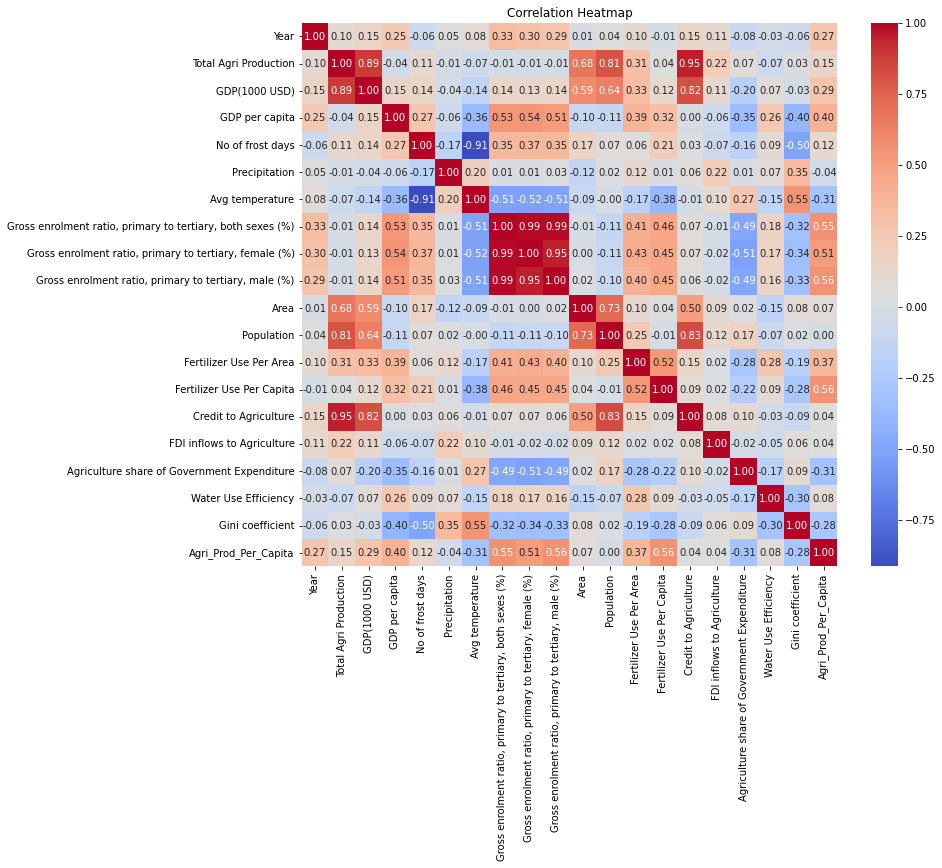

In [63]:
#Plot correlation heatmap 

plt.figure(figsize=(12, 10))
sns.heatmap(imputed_agri_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")

plt.show()


### Drop highly correlated columns

In [64]:
# Drop highly correlated columns
corr_matrix = imputed_agri_data.corr()

columns_to_drop = set()

# Iterate through the upper triangle of the correlation matrix
for i in range(len(corr_matrix.columns)):
   
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.96:
            print(corr_matrix.columns[i])
            print('Correlated with', corr_matrix.columns[j])
            columns_to_drop.add(corr_matrix.columns[i])

# Drop the highly correlated columns
imputed_agri_data = imputed_agri_data.drop(columns=columns_to_drop, axis=1)

imputed_agri_data

Gross enrolment ratio, primary to tertiary, female (%)
Correlated with Gross enrolment ratio, primary to tertiary, both sexes (%)
Gross enrolment ratio, primary to tertiary, male (%)
Correlated with Gross enrolment ratio, primary to tertiary, both sexes (%)


,Country,Year,Total Agri Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)",Area,Population,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Agri_Prod_Per_Capita
0,Albania,1993.0,1885819.0,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,1126.0,3300711.0,25.49,5.42,NaN,642888.0,2.93,0.26,0.270103,571.337206
1,Albania,1994.0,1824978.0,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,1126.0,3293999.0,21.04,4.48,NaN,642888.0,2.93,0.26,0.270103,554.031134
2,Albania,1995.0,1464974.0,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,1127.0,3284364.0,15.67,3.34,NaN,642888.0,2.93,0.26,0.270103,446.044957
3,Albania,1996.0,1602148.0,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,1131.0,3271331.0,9.25,1.99,NaN,642888.0,2.93,0.26,0.270103,489.754170
4,Albania,1997.0,1431983.0,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,1135.0,3253719.0,7.43,1.60,NaN,642888.0,2.93,0.26,0.277984,440.106537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015.0,8833548.0,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,14467.6,3402818.0,102.52,82.61,48841471.0,42023232.0,0.91,0.21,0.401288,2595.950768
1943,Uruguay,2016.0,8067775.0,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,14265.3,3413766.0,135.50,99.90,45199938.0,182055671.0,0.94,0.21,0.396955,2363.306389
1944,Uruguay,2017.0,8943169.0,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,14222.9,3422200.0,138.98,100.32,45811604.0,-88928363.0,0.88,0.17,0.394645,2613.280638
1945,Zimbabwe,2012.0,1824286.0,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,16200.0,13265331.0,17.81,5.50,NaN,NaN,5.67,0.04,NaN,137.522841


### Pandas Profiling
Pandas Profiling is an open-source tool written in Python that has the ability to generate interactive HTML reports which detail the types of data within the dataset; Highlights missing values; Provides descriptive statistics including mean, standard deviation and skewness; Creates histograms and returns any potential correlations.

The profile report for the merged dataset can be found at:
https://saumyasucharita.github.io/Agriculture-Data-Analysis/report.html

Reference:
https://towardsdatascience.com/learning-pandas-profiling-fc533336edc7
https://www.analyticsvidhya.com/blog/2021/06/generate-reports-using-pandas-profiling-deploy-using-streamlit/

In [65]:
#Pandas Profiling - Takes minutes to run
#https://www.analyticsvidhya.com/blog/2021/06/generate-reports-using-pandas-profiling-deploy-using-streamlit/
profile = ProfileReport(imputed_agri_data, title='Pandas Profiling Report', explorative=True)

# Generate the report
profile.to_file("docs/report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Check correlation coefficients of well-producing developed countries

In [66]:
#Checking correlation coefficients of well-producing developed countries
#Create a dictionary of column name and its count
column_count = {}
country_corr = []

# countries_group1 = ['Greece', 'Denmark', 'Spain', 'Australia', 'France', 'New Zealand', 'Türkiye', 'Republic of Korea', 'Ireland', 'Italy']
countries_group1 = ['Greece', 'Denmark', 'Australia',
       'New Zealand', 'France', 'Spain', 'Ireland', 'Uruguay', 'Costa Rica',
       'Republic of Korea', 'Italy', 'Türkiye', 'Japan', 'Romania']
correlation_threshold = 0.3
for country in countries_group1:
    agri_country = imputed_agri_data[imputed_agri_data['Country'] == country]
    corr_with_gross_prod = agri_country.corr()["Agri_Prod_Per_Capita"]
    country_correlations = {"Country": country}
#     country_correlations = {
#         "Country": country,
#         **{column: round(correlation, 2) for column, correlation in corr_with_gross_prod.items() if abs(correlation) >= correlation_threshold}
#     }
#     country_corr.append(country_correlations)
# corr_df = pd.DataFrame(country_corr)
    for column, correlation in corr_with_gross_prod.items():
                country_correlations[column] = round(correlation, 2)
                if correlation >= correlation_threshold or correlation <= -correlation_threshold:
                    print(f"Country: {country}, Column: {column}, Correlation: {round(correlation,2)}")
                    if column in column_count:
                        column_count[column] += 1
                    else:
                        column_count[column] = 1
    country_corr.append(country_correlations)
corr_df = pd.DataFrame(country_corr)
# corr_df.to_excel("Correlation_data.xlsx", index=False)


Country: Greece, Column: Year, Correlation: 0.63
Country: Greece, Column: Total Agri Production, Correlation: 0.99
Country: Greece, Column: GDP(1000 USD), Correlation: 0.77
Country: Greece, Column: GDP per capita, Correlation: 0.79
Country: Greece, Column: No of frost days, Correlation: -0.34
Country: Greece, Column: Precipitation, Correlation: 0.4
Country: Greece, Column: Avg temperature, Correlation: 0.34
Country: Greece, Column: Gross enrolment ratio, primary to tertiary, both sexes (%), Correlation: 0.69
Country: Greece, Column: Area, Correlation: -0.62
Country: Greece, Column: Fertilizer Use Per Area, Correlation: -0.56
Country: Greece, Column: Fertilizer Use Per Capita, Correlation: -0.54
Country: Greece, Column: Credit to Agriculture, Correlation: -0.4
Country: Greece, Column: Water Use Efficiency, Correlation: -0.73
Country: Greece, Column: Agri_Prod_Per_Capita, Correlation: 1.0
Country: Denmark, Column: Total Agri Production, Correlation: 0.99
Country: Denmark, Column: GDP(100

In [67]:
del column_count['Year']
del column_count['Total Agri Production']
del column_count['Agri_Prod_Per_Capita']

In [68]:
for column, count in column_count.items():
                    if count >= 4:
                        print(f"Column: {column}, Count: {count}")

Column: GDP(1000 USD), Count: 11
Column: GDP per capita, Count: 11
Column: Avg temperature, Count: 7
Column: Gross enrolment ratio, primary to tertiary, both sexes (%), Count: 9
Column: Area, Count: 9
Column: Fertilizer Use Per Area, Count: 6
Column: Fertilizer Use Per Capita, Count: 8
Column: Water Use Efficiency, Count: 8
Column: Agriculture share of Government Expenditure, Count: 7
Column: Gini coefficient, Count: 6
Column: Population, Count: 8
Column: FDI inflows to Agriculture, Count: 5


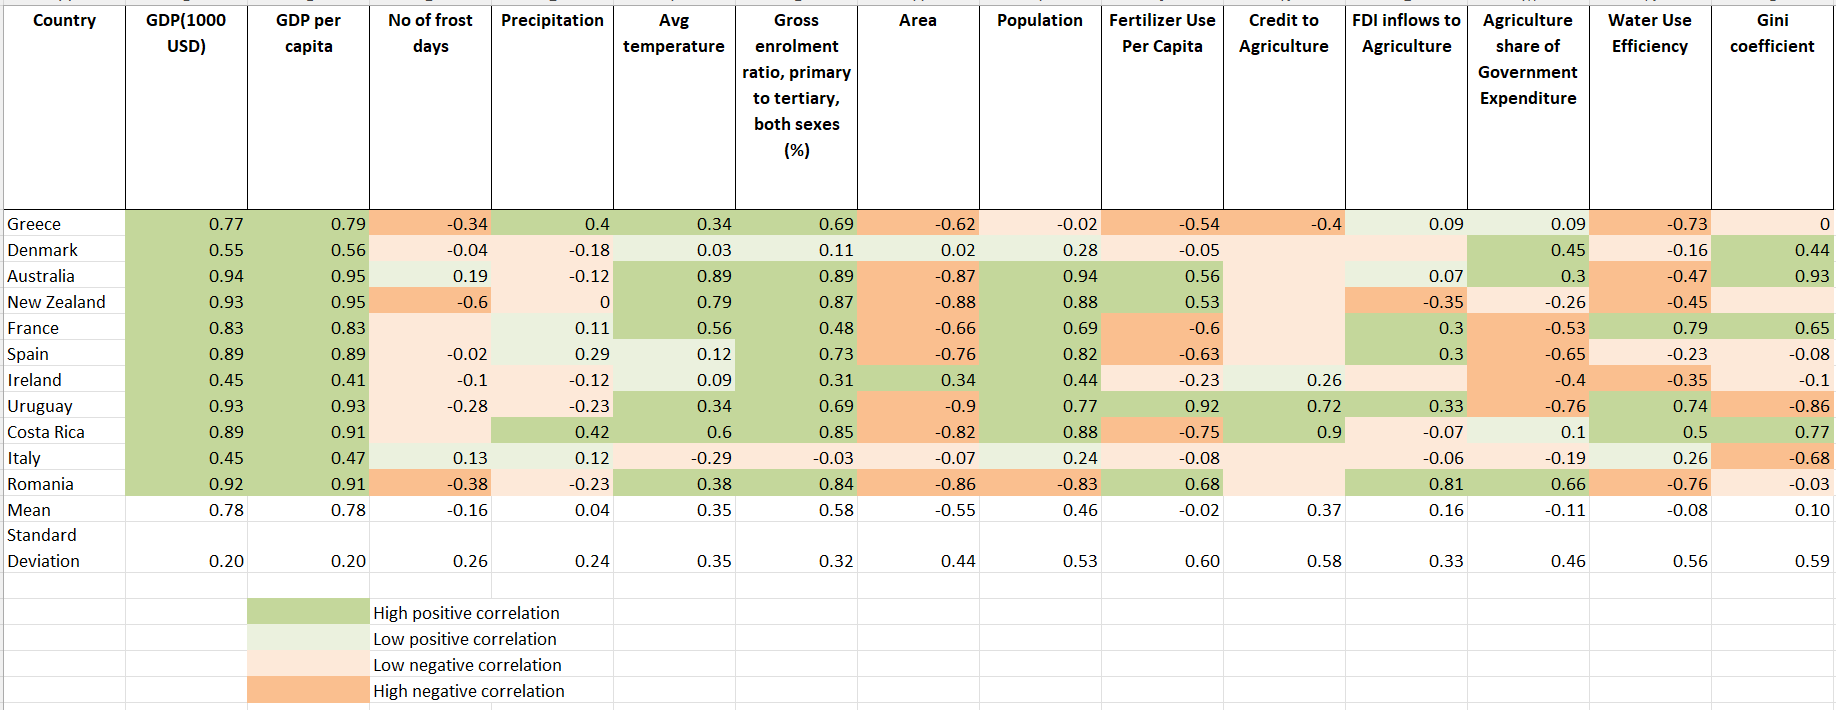

## Perform hypothesis testing(T-test) to find significant factors of agricultural production

**Independent Samples t Test** compares the means of two independent groups in order to determine whether there is statistical evidence that the associated population means are significantly different. <br/>
**Null Hypothesis:** The null hypothesis typically states that there is no significant difference between the means of the two groups. <br/>
Reference: <br/>https://libguides.library.kent.edu/spss/independentttest#:~:text=The%20Independent%20Samples%20t%20Test%20compares%20the%20means%20of%20two,Independent%20t%20Test

In [69]:
#Perform Hypothesis testing
countries_group1 = ['Greece', 'Denmark', 'Australia', 'New Zealand', 'France', 'Spain', 'Ireland', 'Uruguay', 'Costa Rica', 'Republic of Korea', 'Italy', 'Türkiye', 'Japan', 'Romania']
countries_group2 = ['Ethiopia', 'India', 'Kenya', 'Indonesia', 'Bangladesh']
high_producing_countries = imputed_agri_data[imputed_agri_data['Country'].isin(countries_group1)]
low_producing_countries = imputed_agri_data[imputed_agri_data['Country'].isin(countries_group2)]



In [70]:
"""This function conducts an independent samples t-test to compare the means of a specified factor between high and low producing countries.
The factor parameter represents the variable of interest for the t-test. """
def perform_ttest(factor):
    significance = "Not Significant"
    high_producing_factor = high_producing_countries[factor]
    low_producing_factor = low_producing_countries[factor]

    t_stat, p_value = ttest_ind(high_producing_factor, low_producing_factor)

    if p_value < 0.05:
        significance = "Significant"
        print("Reject the null hypothesis. The factor "+ factor + " is significantly associated.")
    else:
        print("Fail to reject the null hypothesis. The factor "+ factor + " is not significantly associated.")
    return significance

In [71]:
factors = ['GDP per capita', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Area', 'Fertilizer Use Per Capita', 'Water Use Efficiency', 'Agriculture share of Government Expenditure', 'Gini coefficient', 'Population', 'FDI inflows to Agriculture']

In [72]:
significance = []
for factor in factors:
    sig = perform_ttest(factor)
    significance.append(sig)

Reject the null hypothesis. The factor GDP per capita is significantly associated.
Reject the null hypothesis. The factor Avg temperature is significantly associated.
Reject the null hypothesis. The factor Gross enrolment ratio, primary to tertiary, both sexes (%) is significantly associated.
Reject the null hypothesis. The factor Area is significantly associated.
Reject the null hypothesis. The factor Fertilizer Use Per Capita is significantly associated.
Reject the null hypothesis. The factor Water Use Efficiency is significantly associated.
Reject the null hypothesis. The factor Agriculture share of Government Expenditure is significantly associated.
Fail to reject the null hypothesis. The factor Gini coefficient is not significantly associated.
Reject the null hypothesis. The factor Population is significantly associated.
Fail to reject the null hypothesis. The factor FDI inflows to Agriculture is not significantly associated.


## Provide insights using visualizations

In [73]:
#Provide insights using visualizations

# countries_group1 = ['Greece', 'Denmark', 'Australia', 'New Zealand', 'France', 'Spain', 'Ireland', 'Uruguay', 'Costa Rica', 'Republic of Korea', 'Italy', 'Türkiye', 'Japan', 'Romania']
# countries_group2 = ['Ethiopia', 'India', 'Kenya', 'Indonesia', 'Bangladesh']
# high_producing_countries = imputed_agri_data[imputed_agri_data['Country'].isin(countries_group1)]
# low_producing_countries = imputed_agri_data[imputed_agri_data['Country'].isin(countries_group2)]
def plot_scatterplots(factor):
    factor_low = low_producing_countries[factor]  # Replace with your low-producing data
    factor_high = high_producing_countries[factor]  # Replace with your high-producing data
    agri_production_low = low_producing_countries['Agri_Prod_Per_Capita']  # Replace with your low-producing data
    agri_production_high = high_producing_countries['Agri_Prod_Per_Capita']  # Replace with your high-producing data

    plt.figure(figsize=(10, 6))

    # Scatter plot for low-producing countries
    plt.scatter(factor_low, agri_production_low, c='red', label='Low-Producing', marker='o')

    # Scatter plot for high-producing countries
    plt.scatter(factor_high, agri_production_high, c='blue', label='High-Producing', marker='s')

    plt.xlabel(factor)
    plt.ylabel('Agricultural Production per capita')
    plt.title('Scatter Plot of '+factor+' vs. Agricultural Production')

    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


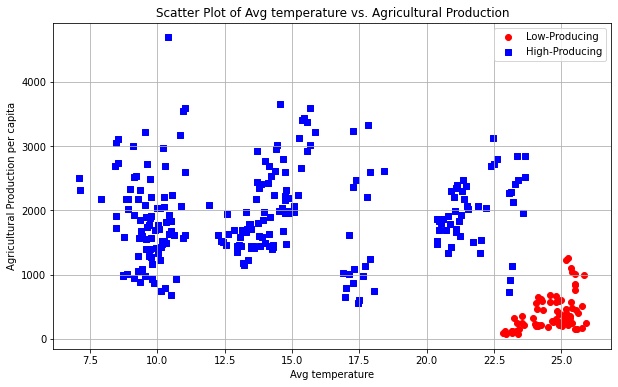

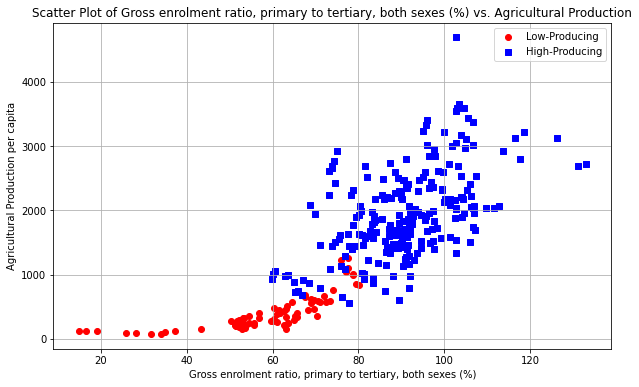

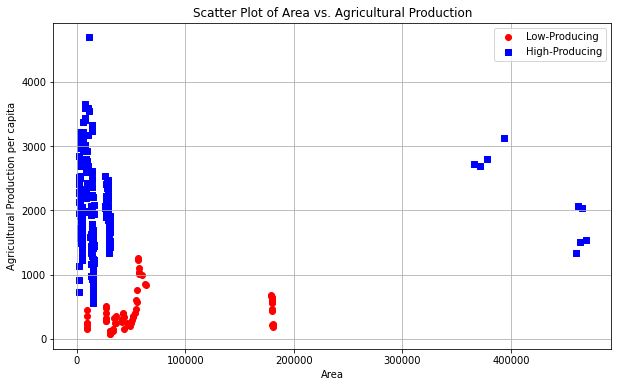

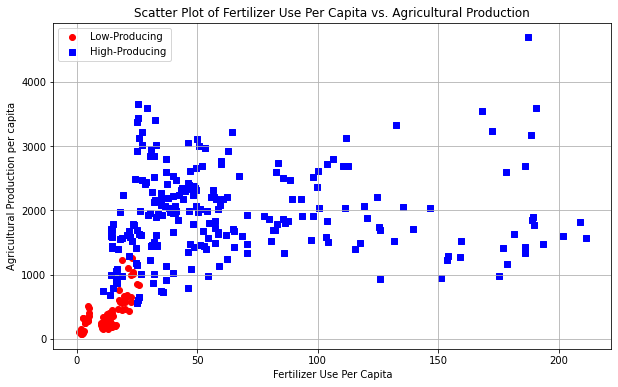

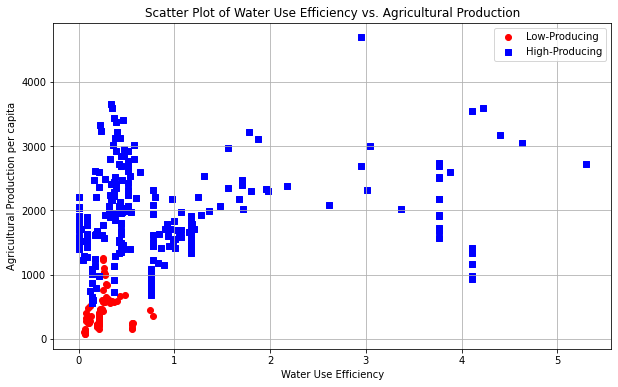

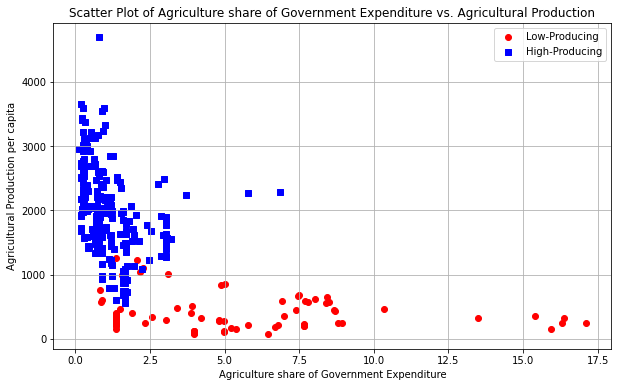

In [74]:
sig_factors = ['Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Area', 'Fertilizer Use Per Capita', 'Water Use Efficiency', 'Agriculture share of Government Expenditure']
for factor in sig_factors:
    plot_scatterplots(factor)

From the scatter plots plotted above for the significant factors:
- The Average temperature of high-producing nations lie below 24 degree Celsius whereas low-producing nations have high average temperature ranging from 22.5 to 27 degree celsius. 
- Low-producing nations have less gross enrolment ratio in education(both sexes) as compared to high-producing nations. They should strive to have at least 80% enrolment in education.
- Even with less area high-producing nations are having higher agricultural production per capita.
- High-producing nations use higher amounts of fertilizer per capita.
- High and low-producing nations have same water use efficiency.
- Low-producing nations have higher agriculture share of government expenditure.

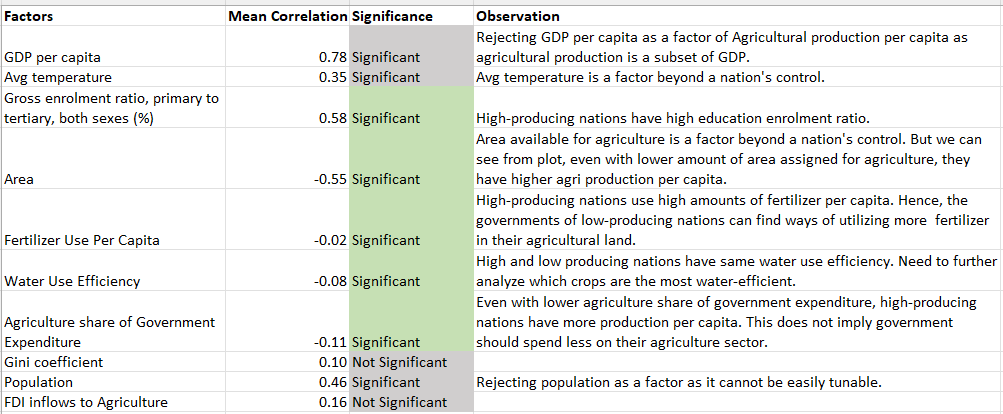

## Building Model
### Import FAOSTAT crops dataset

In [75]:
#Import FAOSTAT Crops data
fao_crops_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Crops.csv')
fao_crops_data

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112.0,Maize (corn),1961,1961,ha,500000.00,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,112.0,Maize (corn),1961,1961,100 g/ha,14000.00,E,Estimated value,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,112.0,Maize (corn),1961,1961,t,700000.00,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112.0,Maize (corn),1962,1962,ha,500000.00,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,112.0,Maize (corn),1962,1962,100 g/ha,14000.00,E,Estimated value,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231300,QCL,Crops and livestock products,716,Zimbabwe,5419,Yield,1530.0,Sweet potatoes,2020,2020,100 g/ha,33191.00,E,Estimated value,NaN
231301,QCL,Crops and livestock products,716,Zimbabwe,5510,Production,1530.0,Sweet potatoes,2020,2020,t,51399.75,I,Imputed value,NaN
231302,QCL,Crops and livestock products,716,Zimbabwe,5312,Area harvested,1530.0,Sweet potatoes,2021,2021,ha,18333.00,A,Official figure,NaN
231303,QCL,Crops and livestock products,716,Zimbabwe,5419,Yield,1530.0,Sweet potatoes,2021,2021,100 g/ha,38370.00,A,Official figure,NaN


In [76]:
fao_crops_data.Item.unique()

array(['Maize (corn)', 'Millet', 'Rice', 'Sugar cane', 'Dates', 'Okra',
       'Sorghum', 'Bananas', 'Groundnuts, excluding shelled',
       'Other tropical fruits, n.e.c.', 'Coffee, green', 'Sweet potatoes',
       'Mangoes, guavas and mangosteens', 'Papayas', 'Cow peas, dry'],
      dtype=object)

In [77]:
#Filter the dataframe on 5 selected crops
selected_crops = ['Maize (corn)', 'Rice', 'Sugar cane', 'Bananas', 'Sweet potatoes']
fao_crops_data = fao_crops_data[fao_crops_data['Item'].isin(selected_crops)]
fao_crops_data

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112.0,Maize (corn),1961,1961,ha,500000.00,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,112.0,Maize (corn),1961,1961,100 g/ha,14000.00,E,Estimated value,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,112.0,Maize (corn),1961,1961,t,700000.00,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112.0,Maize (corn),1962,1962,ha,500000.00,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,112.0,Maize (corn),1962,1962,100 g/ha,14000.00,E,Estimated value,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231300,QCL,Crops and livestock products,716,Zimbabwe,5419,Yield,1530.0,Sweet potatoes,2020,2020,100 g/ha,33191.00,E,Estimated value,NaN
231301,QCL,Crops and livestock products,716,Zimbabwe,5510,Production,1530.0,Sweet potatoes,2020,2020,t,51399.75,I,Imputed value,NaN
231302,QCL,Crops and livestock products,716,Zimbabwe,5312,Area harvested,1530.0,Sweet potatoes,2021,2021,ha,18333.00,A,Official figure,NaN
231303,QCL,Crops and livestock products,716,Zimbabwe,5419,Yield,1530.0,Sweet potatoes,2021,2021,100 g/ha,38370.00,A,Official figure,NaN


In [78]:
#Find the relationship between Area harvested and Production
#Pivot the dataframe
pivoted_crops_data = fao_crops_data.pivot_table(index=['Area', 'Year', 'Item'], columns='Element', values='Value')
pivoted_crops_data.reset_index(inplace=True)

pivoted_crops_data.columns.name = None  # Remove the 'Element' name
pivoted_crops_data = pivoted_crops_data.rename(columns={'Area': 'Country'})

pivoted_crops_data

,Country,Year,Item,Area harvested,Production,Yield
0,Afghanistan,1961,Maize (corn),500000.0,700000.00,14000.0
1,Afghanistan,1961,Rice,210000.0,319000.00,15190.0
2,Afghanistan,1961,Sugar cane,1800.0,45000.00,250000.0
3,Afghanistan,1962,Maize (corn),500000.0,700000.00,14000.0
4,Afghanistan,1962,Rice,210000.0,319000.00,15190.0
...,...,...,...,...,...,...
37358,Zimbabwe,2021,Bananas,22614.0,189498.85,83795.0
37359,Zimbabwe,2021,Maize (corn),957793.0,1469664.00,15344.0
37360,Zimbabwe,2021,Rice,3466.0,2908.00,8390.0
37361,Zimbabwe,2021,Sugar cane,47000.0,3450000.00,734043.0


In [79]:
countries_group2 = ['Ethiopia', 'India', 'Kenya', 'Indonesia', 'Bangladesh']
filtered_df = pivoted_crops_data[pivoted_crops_data['Country'].isin(countries_group2)]

# Plot production over years for each crop in subplots
crops = pivoted_crops_data['Item'].unique()



#### Data Visualization

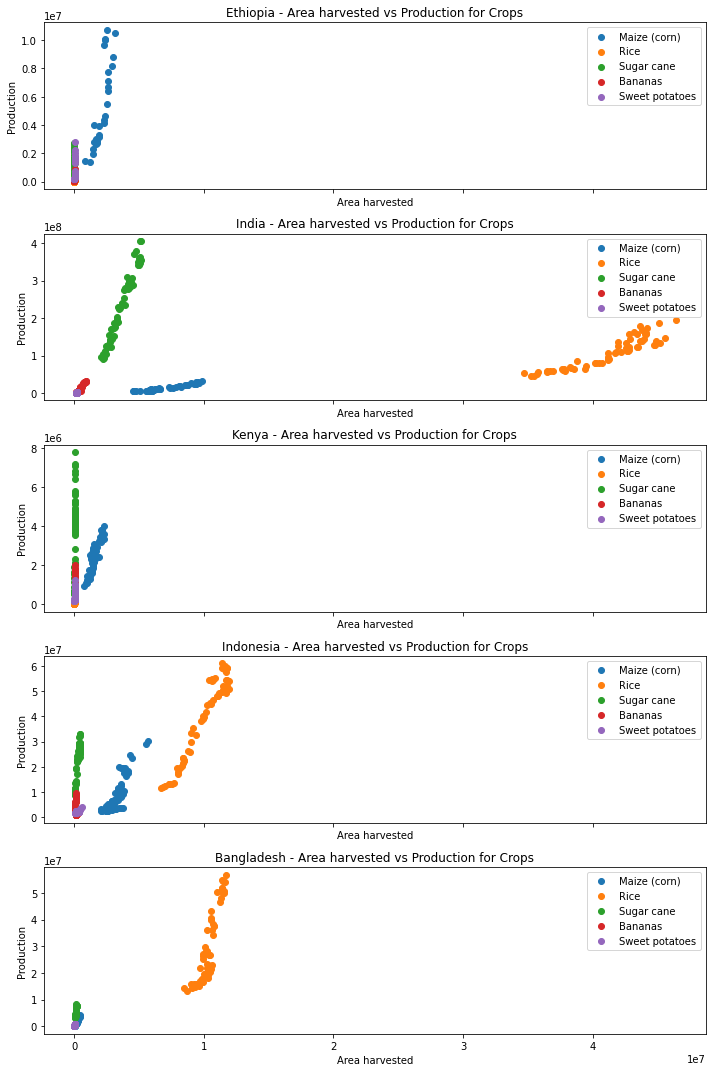

In [80]:
# Create subplots
fig, axes = plt.subplots(nrows=len(countries_group2), ncols=1, figsize=(10, 15), sharex=True)

# Plot Area harvested vs Production for each crop in each subplot
for i, country in enumerate(countries_group2):
    country_data = filtered_df[filtered_df['Country'] == country]
    axes[i].set_title(f'{country} - Area harvested vs Production for Crops')

    for crop in crops:
        crop_data = country_data[country_data['Item'] == crop]
        axes[i].scatter(crop_data['Area harvested'], crop_data['Production'], label=crop)

    axes[i].set_xlabel('Area harvested')
    axes[i].set_ylabel('Production')
    axes[i].legend()

plt.tight_layout()
plt.show()

From the plots above, we can say that Sugar cane and Maize utilize less Area in comparision to Rice.

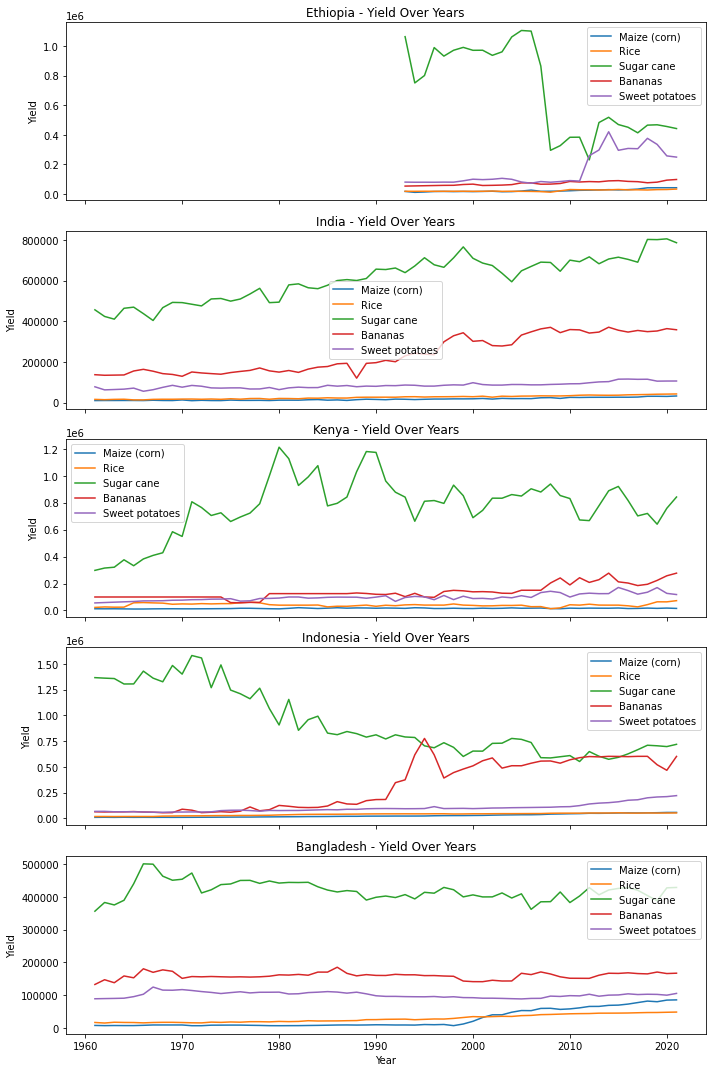

In [81]:
# Create subplots
fig, axes = plt.subplots(nrows=len(countries_group2), ncols=1, figsize=(10, 15), sharex=True)
#Plot Yield vs Time
for i, country in enumerate(countries_group2):
    country_data = filtered_df[filtered_df['Country'] == country]
    axes[i].set_title(f'{country} - Yield Over Years')

    for crop in crops:
        crop_data = country_data[country_data['Item'] == crop]
        axes[i].plot(crop_data['Year'], crop_data['Yield'], label=crop)

    axes[i].set_ylabel('Yield')
    axes[i].legend()

plt.xlabel('Year')
plt.tight_layout()
plt.show()

Focus on high-yield crop for each country:
1. Ethiopia - Sugar cane, Sweet Potatoes
2. India - Sugar cane, Bananas
3. Kenya - Sugar cane, Bananas
4. Indonesia - Sugar cane, Bananas
5. Bangladesh - Sugar cane, Bananas

Let's build a regression model to predict sugar cane production with our master dataset.

In [82]:
crops_data_sugarcane = pivoted_crops_data[pivoted_crops_data['Item'] == 'Sugar cane']
crops_data_sugarcane

,Country,Year,Item,Area harvested,Production,Yield
2,Afghanistan,1961,Sugar cane,1800.0,45000.0,250000.0
5,Afghanistan,1962,Sugar cane,1800.0,45000.0,250000.0
8,Afghanistan,1963,Sugar cane,1800.0,45000.0,250000.0
11,Afghanistan,1964,Sugar cane,1800.0,45000.0,250000.0
14,Afghanistan,1965,Sugar cane,2000.0,51000.0,255000.0
...,...,...,...,...,...,...
37341,Zimbabwe,2017,Sugar cane,41000.0,3101000.0,756341.0
37346,Zimbabwe,2018,Sugar cane,45000.0,3582994.0,796221.0
37351,Zimbabwe,2019,Sugar cane,46000.0,3562000.0,774348.0
37356,Zimbabwe,2020,Sugar cane,47000.0,3543771.0,753994.0


In [83]:
crops_data_sugarcane = crops_data_sugarcane.dropna()

In [84]:
crops_data_sugarcane.rename(columns={'Area harvested': 'Sugarcane_Area', 'Production': 'Sugarcane_Production'}, inplace=True)
crops_data_sugarcane = crops_data_sugarcane[['Country', 'Year', 'Sugarcane_Area', 'Sugarcane_Production' ]]
crops_data_sugarcane

C:\Users\saumy\AppData\Local\Temp\ipykernel_1036\590703110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crops_data_sugarcane.rename(columns={'Area harvested': 'Sugarcane_Area', 'Production': 'Sugarcane_Production'}, inplace=True)


,Country,Year,Sugarcane_Area,Sugarcane_Production
2,Afghanistan,1961,1800.0,45000.0
5,Afghanistan,1962,1800.0,45000.0
8,Afghanistan,1963,1800.0,45000.0
11,Afghanistan,1964,1800.0,45000.0
14,Afghanistan,1965,2000.0,51000.0
...,...,...,...,...
37341,Zimbabwe,2017,41000.0,3101000.0
37346,Zimbabwe,2018,45000.0,3582994.0
37351,Zimbabwe,2019,46000.0,3562000.0
37356,Zimbabwe,2020,47000.0,3543771.0


### Merge with master dataset

In [85]:
#Merge with master dataset

sugarcane_agri_data = pd.merge(imputed_agri_data, crops_data_sugarcane, how='inner', on=['Country','Year'])
sugarcane_agri_data

,Country,Year,Total Agri Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)",...,Fertilizer Use Per Area,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Agri_Prod_Per_Capita,Sugarcane_Area,Sugarcane_Production
0,Angola,2010.0,21285818.0,8.379948e+07,3586.663902,AGO,0.00,99.48,22.35,54.82558,...,8.44,1.48,NaN,NaN,1.08,0.18,NaN,911.044746,13000.0,500000.0
1,Angola,2011.0,21654074.0,1.117897e+08,4608.155097,AGO,0.00,101.85,21.87,61.30225,...,13.55,2.33,NaN,NaN,1.12,0.18,NaN,892.616139,13000.0,510000.0
2,Argentina,1991.0,28459950.0,2.055895e+08,6210.082556,ARG,4.11,80.21,14.24,79.93764,...,6.04,5.06,6.326146e+09,24000000.0,0.93,0.07,NaN,859.667545,292192.0,18200000.0
3,Argentina,1994.0,34014551.0,2.792670e+08,8097.348546,ARG,3.68,68.95,14.89,78.71041,...,16.49,13.40,6.326146e+09,24000000.0,0.93,0.07,NaN,986.252162,238973.0,15200000.0
4,Argentina,1998.0,42289380.0,3.241351e+08,8945.805213,ARG,3.03,71.04,14.63,82.59360,...,27.27,21.41,6.326146e+09,24000000.0,0.93,0.07,NaN,1167.144658,305647.0,19400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,Uruguay,2015.0,8833548.0,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,...,102.52,82.61,4.884147e+07,42023232.0,0.91,0.21,0.401288,2595.950768,7100.0,443000.0
838,Uruguay,2016.0,8067775.0,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,...,135.50,99.90,4.519994e+07,182055671.0,0.94,0.21,0.396955,2363.306389,7600.0,367700.0
839,Uruguay,2017.0,8943169.0,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,...,138.98,100.32,4.581160e+07,-88928363.0,0.88,0.17,0.394645,2613.280638,6200.0,347700.0
840,Zimbabwe,2012.0,1824286.0,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,...,17.81,5.50,NaN,NaN,5.67,0.04,NaN,137.522841,53486.0,3929056.0


In [92]:
#Filter relevant columns
sugarcane_agri_data = sugarcane_agri_data[['Country', 'Year', 'Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Fertilizer Use Per Area', 'Agriculture share of Government Expenditure', 'Water Use Efficiency', 'Sugarcane_Area', 'Sugarcane_Production']]
sugarcane_agri_data['Fertilizer Used for Sugarcane Production'] =  sugarcane_agri_data['Fertilizer Use Per Area'] * sugarcane_agri_data['Sugarcane_Area']
sugarcane_agri_data

,Country,Year,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)",Fertilizer Use Per Area,Agriculture share of Government Expenditure,Water Use Efficiency,Sugarcane_Area,Sugarcane_Production,Fertilizer Used for Sugarcane Production
0,Angola,2010.0,99.48,22.35,54.82558,8.44,1.08,0.18,13000.0,500000.0,109720.00
1,Angola,2011.0,101.85,21.87,61.30225,13.55,1.12,0.18,13000.0,510000.0,176150.00
2,Argentina,1991.0,80.21,14.24,79.93764,6.04,0.93,0.07,292192.0,18200000.0,1764839.68
3,Argentina,1994.0,68.95,14.89,78.71041,16.49,0.93,0.07,238973.0,15200000.0,3940664.77
4,Argentina,1998.0,71.04,14.63,82.59360,27.27,0.93,0.07,305647.0,19400000.0,8334993.69
...,...,...,...,...,...,...,...,...,...,...,...
837,Uruguay,2015.0,103.82,17.88,95.61326,102.52,0.91,0.21,7100.0,443000.0,727892.00
838,Uruguay,2016.0,111.88,17.25,97.38798,135.50,0.94,0.21,7600.0,367700.0,1029800.00
839,Uruguay,2017.0,113.84,18.42,98.66813,138.98,0.88,0.17,6200.0,347700.0,861676.00
840,Zimbabwe,2012.0,50.65,21.80,66.51386,17.81,5.67,0.04,53486.0,3929056.0,952585.66


### Perform Linear Regression using sklearn

In [93]:
""" This function takes a crop name as input and filters the crop_data dataframe for that crop and merges with the master dataset.
It returns a dataframe with relevant columns as output"""
def filter_merge_crop(crop):
    crop_data = pivoted_crops_data[pivoted_crops_data['Item'] == crop]
    crop_data = crop_data.dropna()
    crop_data.rename(columns={'Area harvested': 'Crop_Area', 'Production': 'Crop_Production'}, inplace=True)
    crop_data = crop_data[['Country', 'Year', 'Crop_Area', 'Crop_Production' ]]
    
    #Merge with master dataset
    crop_agri_data = pd.merge(imputed_agri_data, crop_data, how='inner', on=['Country','Year'])
    
    #Filter relevant columns
    crop_agri_data = crop_agri_data[['Country', 'Year', 'Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Fertilizer Use Per Area', 'Agriculture share of Government Expenditure', 'Water Use Efficiency', 'Crop_Area', 'Crop_Production']]
    crop_agri_data['Fertilizer Used for Crop Production'] =  crop_agri_data['Fertilizer Use Per Area'] * crop_agri_data['Crop_Area']
    return crop_agri_data

In [98]:
#Method to perform linear regression
def build_linear_regression():
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Standardize the features 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the model coefficients
    coefficients = pd.DataFrame({'Feature': features.columns, 'Coefficient': model.coef_})
    print(coefficients)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared (R2): {r2}')

In [102]:
#Method to perform linear regression with cross-validation
def build_lr_cross_validation():
    model = LinearRegression()

    # Standardize the features 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    y = target

    num_folds = 5
    cross_val_results = cross_val_score(model, X_scaled, y, cv=num_folds, scoring='neg_mean_squared_error')

    cv_mse = -cross_val_results.mean()

    print(f'Cross-validated Mean Squared Error: {cv_mse}')

    # Calculate RMSE for each fold
    rmse_scores = np.sqrt(-cross_val_results)

    # Print RMSE for each fold
    for i, rmse in enumerate(rmse_scores, 1):
        print(f'Fold {i} RMSE: {rmse}')

    # Print the mean RMSE across all folds
    print(f'Cross-validated Root Mean Squared Error: {np.mean(rmse_scores)}')

In [103]:
#Plot cross-validated predictions
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py

def plot_cross_validated_predictions(crop):
    model = LinearRegression()
     
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    y = target
    num_folds = 5
    y_pred = cross_val_predict(model, X_scaled, y, cv=num_folds)

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions for "+crop)
    plt.tight_layout()
    plt.show()

Starting for  Maize (corn)
                                             Feature   Coefficient
0                                      Precipitation -1.137399e+05
1                                    Avg temperature -4.060669e+05
2  Gross enrolment ratio, primary to tertiary, bo...  6.882012e+05
3                Fertilizer Used for Crop Production  8.063924e+05
4        Agriculture share of Government Expenditure -5.130875e+05
5                               Water Use Efficiency -2.052607e+05
6                                          Crop_Area  5.241516e+06
Mean Squared Error: 7716795680789.544
R-squared (R2): 0.8176533537133841
Cross-validated Mean Squared Error: 9510472506641.742
Fold 1 RMSE: 3810913.417102854
Fold 2 RMSE: 2885553.792627371
Fold 3 RMSE: 3636641.0287496983
Fold 4 RMSE: 2642951.75087883
Fold 5 RMSE: 2119558.6429605614
Cross-validated Root Mean Squared Error: 3019123.7264638627


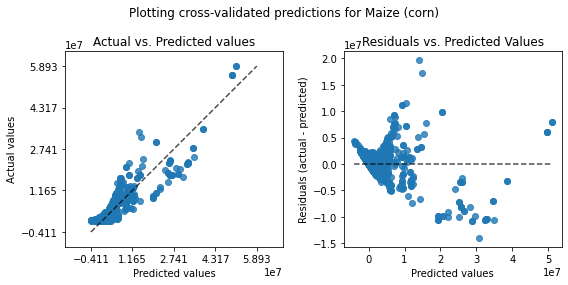

Starting for  Rice
                                             Feature   Coefficient
0                                      Precipitation  1.122029e+06
1                                    Avg temperature -4.530372e+02
2  Gross enrolment ratio, primary to tertiary, bo...  1.581196e+04
3                Fertilizer Used for Crop Production  6.895823e+06
4        Agriculture share of Government Expenditure -4.731956e+05
5                               Water Use Efficiency -2.871554e+05
6                                          Crop_Area  1.463137e+07
Mean Squared Error: 8094793671548.963
R-squared (R2): 0.9816884369243034
Cross-validated Mean Squared Error: 14312792642088.256
Fold 1 RMSE: 1295044.9307836136
Fold 2 RMSE: 2305040.852396442
Fold 3 RMSE: 7742907.925503742
Fold 4 RMSE: 1563373.4541906402
Fold 5 RMSE: 1475414.7912976178
Cross-validated Root Mean Squared Error: 2876356.390834411


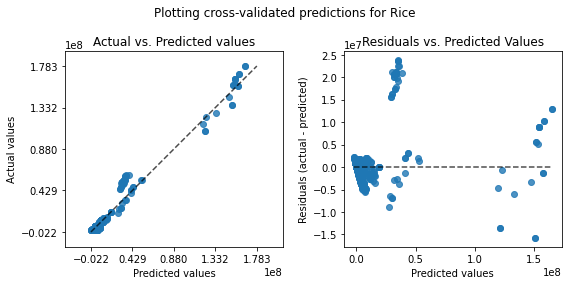

Starting for  Sugar cane
                                             Feature   Coefficient
0                                      Precipitation  2.810947e+05
1                                    Avg temperature  3.527893e+05
2  Gross enrolment ratio, primary to tertiary, bo...  1.269822e+06
3                Fertilizer Used for Crop Production  8.170693e+06
4        Agriculture share of Government Expenditure -1.430707e+05
5                               Water Use Efficiency -4.232932e+05
6                                          Crop_Area  6.436716e+07
Mean Squared Error: 29908944058573.527
R-squared (R2): 0.9950875489167095
Cross-validated Mean Squared Error: 57749221634627.98
Fold 1 RMSE: 11559608.203994906
Fold 2 RMSE: 8841524.071740769
Fold 3 RMSE: 4442895.251840855
Fold 4 RMSE: 5978878.648484153
Fold 5 RMSE: 4632786.453094119
Cross-validated Root Mean Squared Error: 7091138.52583096


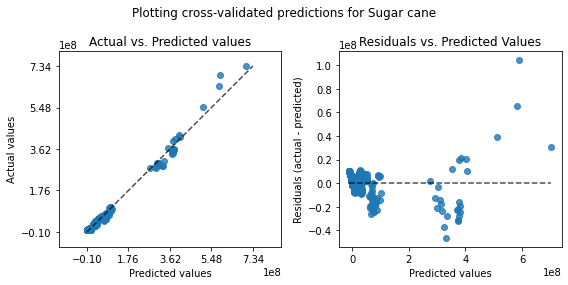

Starting for  Bananas
                                             Feature   Coefficient
0                                      Precipitation  6.047343e+04
1                                    Avg temperature -5.102494e+04
2  Gross enrolment ratio, primary to tertiary, bo... -4.737382e+04
3                Fertilizer Used for Crop Production  2.160680e+06
4        Agriculture share of Government Expenditure  8.063204e+04
5                               Water Use Efficiency -1.172196e+03
6                                          Crop_Area  9.185983e+05
Mean Squared Error: 2543342019118.4697
R-squared (R2): 0.906923593882554
Cross-validated Mean Squared Error: 6775052209197.2295
Fold 1 RMSE: 2704828.547291744
Fold 2 RMSE: 4676931.586099658
Fold 3 RMSE: 1475228.1615803912
Fold 4 RMSE: 483954.6799140089
Fold 5 RMSE: 1508298.46308832
Cross-validated Root Mean Squared Error: 2169848.2875948246


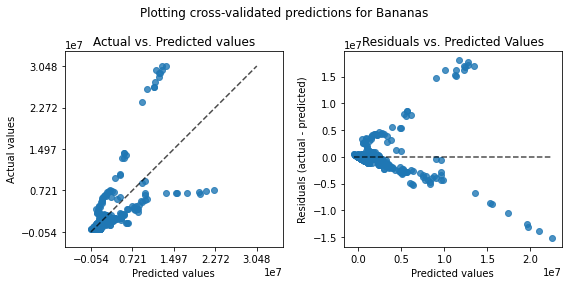

Starting for  Sweet potatoes
                                             Feature    Coefficient
0                                      Precipitation   22593.955638
1                                    Avg temperature  -26065.615886
2  Gross enrolment ratio, primary to tertiary, bo...  -37759.235260
3                Fertilizer Used for Crop Production  246753.499810
4        Agriculture share of Government Expenditure   -1952.632443
5                               Water Use Efficiency  -21172.839217
6                                          Crop_Area  310126.793767
Mean Squared Error: 40701566001.62671
R-squared (R2): 0.8671298511549184
Cross-validated Mean Squared Error: 187016058288.2355
Fold 1 RMSE: 175047.6227485994
Fold 2 RMSE: 171850.44582459776
Fold 3 RMSE: 431141.900025698
Fold 4 RMSE: 802060.7512687405
Fold 5 RMSE: 213825.2997135351
Cross-validated Root Mean Squared Error: 358785.2039162341


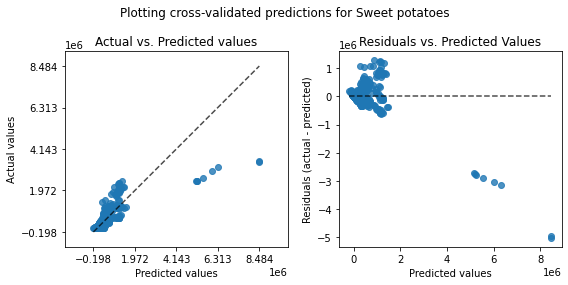

In [104]:
#Script to build regression model for crops
selected_crops = ['Maize (corn)', 'Rice', 'Sugar cane', 'Bananas', 'Sweet potatoes']
for crop in selected_crops:
    print('Starting for ', crop)
    crop_agri_data = filter_merge_crop(crop)
    
    df = crop_agri_data.dropna()

    # Select features (independent variables) and target variable
    features = df[['Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 
                   'Fertilizer Used for Crop Production', 'Agriculture share of Government Expenditure', 
                   'Water Use Efficiency', 'Crop_Area']]

    target = df['Crop_Production']
    
    build_linear_regression()
    build_lr_cross_validation()
    plot_cross_validated_predictions(crop)

### Perform Linear Regression using statsmodel library


In [105]:
def build_linear_regression_statsmodels(features, target):
   
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Standardize the features 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
   
    # Add a constant term to the features matrix
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    # Fit the model
    model = sm.OLS(y_train, X_train_scaled).fit()

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Print the summary which includes coefficients, p-values, etc.
    print(model.summary())

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared (R2): {r2}')

    return model

#### Dependent variable- Crop Production

In [106]:
#Script to build regression model for crops
selected_crops = ['Maize (corn)', 'Rice', 'Sugar cane', 'Bananas', 'Sweet potatoes']
for crop in selected_crops:
    print('Starting for ', crop)
    crop_agri_data = filter_merge_crop(crop)
    
    df = crop_agri_data.dropna()

    # Select features (independent variables) and target variable
    features = df[['Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 
                   'Fertilizer Used for Crop Production', 'Agriculture share of Government Expenditure', 
                   'Water Use Efficiency', 'Crop_Area']]

    target = df['Crop_Production']
    
    build_linear_regression_statsmodels(features, target)

Starting for  Maize (corn)
                            OLS Regression Results                            
Dep. Variable:        Crop_Production   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     812.6
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:33:20   Log-Likelihood:                -19155.
No. Observations:                1180   AIC:                         3.833e+04
Df Residuals:                    1172   BIC:                         3.837e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.523e+06   7

#### Dependent variable- Crop Yield

In [107]:
#Including Crop Yield column
def filter_merge_crop2(crop):
    crop_data = pivoted_crops_data[pivoted_crops_data['Item'] == crop]
    crop_data = crop_data.dropna()
    crop_data.rename(columns={'Area harvested': 'Crop_Area', 'Production': 'Crop_Production', 'Yield': 'Crop_Yield'}, inplace=True)
    crop_data = crop_data[['Country', 'Year', 'Crop_Area', 'Crop_Production', 'Crop_Yield' ]]
    
    #Merge with master dataset
    crop_agri_data = pd.merge(imputed_agri_data, crop_data, how='inner', on=['Country','Year'])
    
    #Filter relevant columns
    crop_agri_data = crop_agri_data[['Country', 'Year', 'Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Fertilizer Use Per Area', 'Agriculture share of Government Expenditure', 'Water Use Efficiency', 'Crop_Area', 'Crop_Production', 'Crop_Yield']]
#   crop_agri_data['Fertilizer Used for Crop Production'] =  crop_agri_data['Fertilizer Use Per Area'] * crop_agri_data['Crop_Area']
    return crop_agri_data

In [108]:
#Script to build regression model for crops taking target as crop yield
selected_crops = ['Maize (corn)', 'Rice', 'Sugar cane', 'Bananas', 'Sweet potatoes']
for crop in selected_crops:
    print('Starting for ', crop)
    crop_agri_data = filter_merge_crop2(crop)
    
    df = crop_agri_data.dropna()

    # Select features (independent variables) and target variable
    features = df[['Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 
                   'Fertilizer Use Per Area', 'Agriculture share of Government Expenditure', 
                   'Water Use Efficiency', 'Crop_Area', 'Crop_Production']]

    target = df['Crop_Yield']
    
    build_linear_regression_statsmodels(features, target)

Starting for  Maize (corn)
                            OLS Regression Results                            
Dep. Variable:             Crop_Yield   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     144.6
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          8.65e-169
Time:                        13:33:20   Log-Likelihood:                -13801.
No. Observations:                1180   AIC:                         2.762e+04
Df Residuals:                    1171   BIC:                         2.767e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.992e+04    

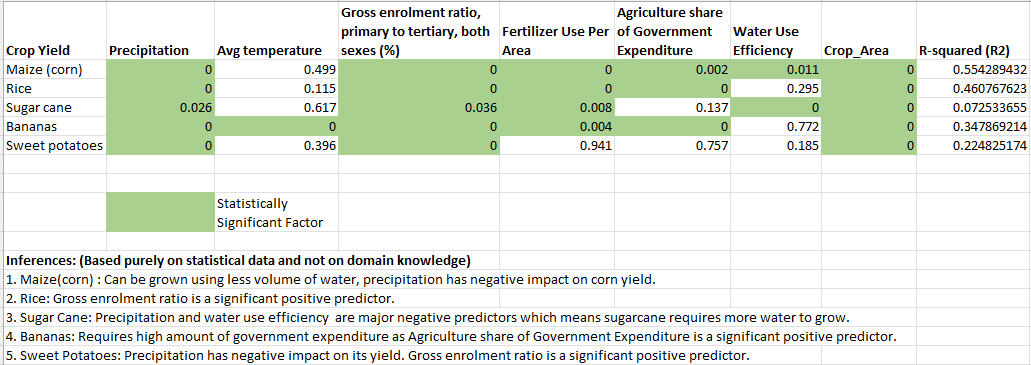

### Implement alternative regression models - Random Forest

In [109]:
#Build Random Forest model
def build_random_forest(features, target):
   
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    #n_estimators: The number of trees in the forest
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared (R2): {r2}')
    print(rf_model.feature_importances_)

In [110]:
#Script to build random forest model for crops taking target as crop yield
selected_crops = ['Maize (corn)', 'Rice', 'Sugar cane', 'Bananas', 'Sweet potatoes']
for crop in selected_crops:
    print(crop)
    crop_agri_data = filter_merge_crop2(crop)
    
    df = crop_agri_data.dropna()

    # Select features (independent variables) and target variable
    features = df[['Precipitation', 'Avg temperature', 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 
                   'Fertilizer Use Per Area', 'Agriculture share of Government Expenditure', 
                   'Water Use Efficiency', 'Crop_Area', 'Crop_Production']]

    target = df['Crop_Yield']
    
    build_random_forest(features, target)

Maize (corn)
Mean Squared Error: 106537836.66651928
R-squared (R2): 0.9054727487058343
[0.16624667 0.11974741 0.13499401 0.18129165 0.07967859 0.19909496
 0.06930608 0.04964063]
Rice
Mean Squared Error: 35904497.339945756
R-squared (R2): 0.8961488342452862
[0.04654026 0.12218491 0.40700554 0.13870429 0.0890071  0.03603338
 0.04915593 0.1113686 ]
Sugar cane
Mean Squared Error: 6036996933.601641
R-squared (R2): 0.8947888724228872
[0.20336827 0.15006146 0.03499031 0.08114137 0.05977984 0.0509694
 0.13951787 0.28017147]
Bananas
Mean Squared Error: 2618631405.304742
R-squared (R2): 0.9026517726786342
[0.23869585 0.06502039 0.05414906 0.18951555 0.10186154 0.11608769
 0.11049381 0.12417612]
Sweet potatoes
Mean Squared Error: 683230986.8127666
R-squared (R2): 0.8330737476498775
[0.25733161 0.1328328  0.08762009 0.04443071 0.03269173 0.11761396
 0.15609671 0.1713824 ]


### Observations/ Conclusions

| Crop          | Precipitation | Avg Temperature | Gross Enrolment Ratio | Fertilizer Use Per Area | Agriculture share of Government Expenditure | Water Use Efficiency | Crop Area | 
|---------------|---------------|-----------------|------------------------|----------------|-------------------------|----------------------|-----------|
| Maize         | 0.1747        | 0.1271          | 0.0977                 | 0.1913         | 0.0823                  | 0.2050               | 0.0720     |
| Rice          | 0.0495        | 0.1361          | 0.3930                 | 0.1423         | 0.0881                  | 0.0376               | 0.0503     |
| Sugar Cane    | 0.1952        | 0.1566          | 0.0357                 | 0.0756         | 0.0606                  | 0.0540               | 0.1380     |
| Bananas       | 0.2328        | 0.0721          | 0.0524                 | 0.1901         | 0.1039                  | 0.1147               | 0.1128     |
| Sweet Potatoes| 0.2522        | 0.1299          | 0.0775                 | 0.0534         | 0.0360                  | 0.1170               | 0.1589     | 


| Crop          | Important factor           |
|---------------|----------------------------|
| Maize         | Water Use Efficiency       |
| Rice          | Gross Enrolment Ratio      |
| Sugar Cane    | Precipitation              |
| Bananas       | Precipitation              |
| Sweet Potatoes| Precipitation              |

### Recommendations
Suggestions for low-producing nations:
1.	**Average Temperature**: We can see from scatter plot that low-producing nations have high average temperature( ranging from 22.5 to 27 degree celsius). So, they can focus on crops which favour high temperature.(Rice, Corn, Sweet potatoes, Sugarcane, Peanuts, Tropical fruits like Mangoes, Papayas, Bananas, Date Palms, Coffee).
2.	**Gross enrolment ratio, primary to tertiary, both sexes (%)**: We can infer from the scatter plot that high-producing nations have high education enrolment ratio. So, the government in low-producing nations can form policies which encourage higher enrolment in education.
3.	**Area**: Area available for agriculture is a factor beyond a nation's control. But we can see from plot, even with lower amount of area assigned for agriculture, they have higher agri production per capita.
4.	**Fertilizer Use Per Capita**: High-producing nations use high amounts of fertilizer per capita. Hence, the governments of low-producing nations can find ways of utilizing more  fertilizer in their agricultural land.
5.	**Water Use Efficiency**: Maize seems to be the most water-efficient crop from the Random forest feature importance results. It can be grown using less volume of water which in turn will increase the profitability of the farmers as it requires less water investment.
6.	**Agriculture share of Government Expenditure**: Even with lower agriculture share of government expenditure, high-producing nations have more production per capita. This does not imply that governments should spend less on their agriculture sector.
7. **Crop Area**: Sugar Cane and Bananas are high-yield crops for many countries which utilize less area in comparision to Rice.